# Detection Layer - 3-Label Classification

In [10]:
# Configuration Section - Easy experiment control
CONFIG = {
    'RANDOM_STATES': 10,           # Number of random states to test
    'ENABLE_CLASSICAL': True,       # Enable classical classifiers
    'ENABLE_STATIC': True,          # Enable static/ensemble classifiers  
    'ENABLE_DES': True,             # Enable Dynamic Ensemble Selection
    'ENABLE_HYPEROPT': True,        # Enable hyperparameter optimization - ENABLED
    'TOP_FEATURES_COUNT': 50,       # Number of top features to select
    'SAVE_PLOTS': True,             # Save plots as SVG files
    'VERBOSE': True                 # Verbose output
}

print("Experiment Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Experiment Configuration:
  RANDOM_STATES: 10
  ENABLE_CLASSICAL: True
  ENABLE_STATIC: True
  ENABLE_DES: True
  ENABLE_HYPEROPT: True
  TOP_FEATURES_COUNT: 50
  SAVE_PLOTS: True
  VERBOSE: True


In [11]:
# Enhanced imports with better error handling
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold
from sklearn.impute import KNNImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE,SMOTENC
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier

# Install and import DESlib
!pip install deslib -q
from deslib.dcs import APosteriori
from deslib.des import KNORAE, KNORAU, KNOP, DESMI

from sklearn.neighbors import LocalOutlierFactor
from sklearn.utils import resample
import warnings
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler
from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, PowerTransformer
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier

# Install and import CatBoost
!pip install catboost -q
from catboost import CatBoostClassifier

# Note: LightGBM commented out as requested
# from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import numpy as np
from scipy.stats import friedmanchisquare, rankdata
import shap

!pip install scikit-posthocs -q
import scikit_posthocs as sp

from sklearn.feature_selection import SelectFromModel
from IPython.display import FileLink, display
import math
from sklearn.ensemble import RandomForestClassifier

!pip install scikit-optimize -q
from skopt.space import Integer, Real
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn import tree
from skopt.space import Real, Integer, Categorical
from skopt.callbacks import VerboseCallback
from deslib.des.knora_e import KNORAE
from deslib.des.knora_u import KNORAU
from deslib.des.knop import KNOP
from deslib.des.meta_des import METADES
from deslib.des.des_knn import DESKNN
from deslib.des.des_p import DESP
from sklearn.model_selection import RandomizedSearchCV

# Set plot style for better visualization
plt.style.use('default')
warnings.filterwarnings('ignore')

### Data Preparation and Analysis
Enhanced data loading with comprehensive statistics

In [12]:
# Enhanced dataset loading with comprehensive analysis
pd.set_option('display.max_rows', 10)
initial_df = pd.read_csv('./3labelv4Classification.csv')

print("="*60)
print("DATASET INFORMATION")
print("="*60)
initial_df.info()
print(f"\nDataset shape: {initial_df.shape}")
print(f"Memory usage: {initial_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\nFirst few rows:")
display(initial_df.head())

# Enhanced target analysis
target_candidates = ['BCaseControlStatus', 'label_encoded']
for col in target_candidates:
    if col in initial_df.columns:
        print(f"\nValue counts for {col}:")
        print(initial_df[col].value_counts())

# Missing values analysis
print(f"\nMissing Values Analysis:")
print("-" * 40)
missing_info = initial_df.isnull().sum()
missing_percent = (missing_info / len(initial_df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing_info,
    'Missing_Percent': missing_percent
}).sort_values('Missing_Percent', ascending=False)

print(f"Columns with missing values: {(missing_info > 0).sum()}")
print(f"Total missing values: {missing_info.sum()}")
print("\nTop 10 columns with most missing values:")
print(missing_df.head(10))

DATASET INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Columns: 134 entries, PtID to MULTIMODAL_COMPLETENESS
dtypes: bool(4), float64(83), int64(12), object(35)
memory usage: 203.0+ KB

Dataset shape: (199, 134)
Memory usage: 0.57 MB

First few rows:


,PtID,DealHypoEp,UndertreatHypo,HighBGDamage,FreqHypoDamage,DangersHighBG,HighBGLevTakeAction,LowBGLevTakeAction,PtCurrA1cGoal,label_encoded,...,medconditions2_word_count,medications2_count,medications2_unique_values,medications2_text_length,medications2_word_count,HAS_TABULAR_DATA,HAS_TEXT_DATA,HAS_TIMESERIES_DATA,HAS_HEALTH_SURVEY,MULTIMODAL_COMPLETENESS
0,1,Disagree,Disagree,Disagree,Agree,Disagree,170.0,80.0,8.0,0,...,137.0,1.0,11.0,723.0,138.0,True,True,True,True,1.0
1,2,Neutral,Disagree,Disagree,Neutral,Agree,175.0,80.0,6.8,1,...,149.0,1.0,11.0,783.0,148.0,True,True,True,True,1.0
2,3,Disagree,Disagree,Disagree,Agree,Disagree,200.0,70.0,7.9,1,...,147.0,1.0,11.0,867.0,162.0,True,True,True,True,1.0
3,4,Disagree,Agree,Agree,Agree,Agree,140.0,65.0,5.4,1,...,146.0,1.0,11.0,867.0,162.0,True,True,True,True,1.0
4,5,Disagree,Disagree,Agree,Agree,Disagree,100.0,70.0,5.0,1,...,171.0,1.0,11.0,998.0,185.0,True,True,True,True,1.0



Value counts for BCaseControlStatus:
Control    100
Case        99
Name: BCaseControlStatus, dtype: int64

Value counts for label_encoded:
1    100
0     99
Name: label_encoded, dtype: int64

Missing Values Analysis:
----------------------------------------
Columns with missing values: 56
Total missing values: 265

Top 10 columns with most missing values:
                               Missing_Count  Missing_Percent
LastFoodIntakeCarbs_BMedChart             47        23.618090
EduLevel_lifestyle                        44        22.110553
Bel70PastMonWSymp_unaware                 33        16.582915
LastFoodIntakeHrs_BMedChart                8         4.020101
SymbDigOTotCorr_BTOTSCORE                  8         4.020101
SymbDigONumErr_BTOTSCORE                   8         4.020101
SymbDigWNumErr_BTOTSCORE                   6         3.015075
TrailMakBTotTime_BTOTSCORE                 6         3.015075
TrailMakBNumErr_BTOTSCORE                  6         3.015075
SymbDigWTotCorr_BTOTS

In [13]:
# Identify the target column - let's assume it's BCaseControlStatus based on the data structure
TARGET_COLUMN = 'BCaseControlStatus'  # Update this if your target is different

# Remove potential data leakage columns - these lion
LEAKAGE_COLUMNS = [ 'PtID',  # Patient ID should not be used as a feature
    'label_encoded',  # This appears to be another encoding of the target
    'label_encoded_BMedChart', 
    'label_encoded_BSample',
    'label_encoded_BTOTSCORE',
    'label_encoded_depression',
    'label_encoded_fear',
    'label_encoded_lifestyle',
    'label_encoded_MOCA',
    'label_encoded_unaware'
]

# All categorical features except for target and leakage columns
cols = initial_df.columns
num_cols = initial_df._get_numeric_data().columns
categorical_features = list(set(cols) - set(num_cols))
if TARGET_COLUMN in categorical_features:
    categorical_features.remove(TARGET_COLUMN)

# Remove leakage columns from categorical features
for leak_col in LEAKAGE_COLUMNS:
    if leak_col in categorical_features:
        categorical_features.remove(leak_col)

print(f"Target column: {TARGET_COLUMN}")
print(f"Removed leakage columns: {LEAKAGE_COLUMNS}")
print(f"Number of categorical features: {len(categorical_features)}")
print(f"Number of numerical features: {len(num_cols)}")

# Label Encode all categorical features, but keep missing values
le_initial_df = initial_df.copy()

# Remove leakage columns entirely
for leak_col in LEAKAGE_COLUMNS:
    if leak_col in le_initial_df.columns:
        le_initial_df = le_initial_df.drop(leak_col, axis=1)
        print(f"Removed leakage column: {leak_col}")

dropped_labels = le_initial_df[TARGET_COLUMN]
le_initial_df = le_initial_df.drop(TARGET_COLUMN, axis=1)

for col in le_initial_df.columns:
    if le_initial_df[col].dtype == 'object':
        le_initial_df[col] = le_initial_df[col].fillna('missing')
        
        label_encoder = LabelEncoder()
        le_initial_df[col] = label_encoder.fit_transform(le_initial_df[col])
        
        missing_value_index = np.where(label_encoder.classes_ == 'missing')[0]
        
        le_initial_df[col] = le_initial_df[col].replace(missing_value_index, np.nan)

le_initial_df = pd.concat([le_initial_df, dropped_labels], axis=1)

Target column: BCaseControlStatus
Removed leakage columns: ['PtID', 'label_encoded', 'label_encoded_BMedChart', 'label_encoded_BSample', 'label_encoded_BTOTSCORE', 'label_encoded_depression', 'label_encoded_fear', 'label_encoded_lifestyle', 'label_encoded_MOCA', 'label_encoded_unaware']
Number of categorical features: 34
Number of numerical features: 99
Removed leakage column: PtID
Removed leakage column: label_encoded
Removed leakage column: label_encoded_BMedChart
Removed leakage column: label_encoded_BSample
Removed leakage column: label_encoded_BTOTSCORE
Removed leakage column: label_encoded_depression
Removed leakage column: label_encoded_fear
Removed leakage column: label_encoded_lifestyle
Removed leakage column: label_encoded_MOCA
Removed leakage column: label_encoded_unaware


In [14]:
# Display processed dataset with summary
print("Processed Dataset Summary:")
print(f"Shape: {le_initial_df.shape}")
print(f"Columns: {list(le_initial_df.columns)}")
le_initial_df

Processed Dataset Summary:
Shape: (199, 124)
Columns: ['DealHypoEp', 'UndertreatHypo', 'HighBGDamage', 'FreqHypoDamage', 'DangersHighBG', 'HighBGLevTakeAction', 'LowBGLevTakeAction', 'PtCurrA1cGoal', 'LastFoodIntakeHrs_BMedChart', 'LastFoodIntakeCarbs_BMedChart', 'Weight_mod_BMedChart', 'Height_mod_BMedChart', 'Value_HBA1C_BSample', 'Value_CPEP_BSample', 'Value_CREAS_BSample', 'Value_GLU_BSample', 'Unnamed: 0_BTOTSCORE', 'BGVisit1_BTOTSCORE', 'HopVerbTr1TotCorr_BTOTSCORE', 'HopVerbTr2TotCorr_BTOTSCORE', 'HopVerbTr3TotCorr_BTOTSCORE', 'HopVerbTr4TotCorr_BTOTSCORE', 'HopVerbNumHits_BTOTSCORE', 'HopVerbSemRelErr_BTOTSCORE', 'HopVerbSemUnRelErr_BTOTSCORE', 'HopVerbNumFalPosErr_BTOTSCORE', 'HopVerbNumIntr_BTOTSCORE', 'SymbDigWTotCorr_BTOTSCORE', 'SymbDigWNumErr_BTOTSCORE', 'SymbDigOTotCorr_BTOTSCORE', 'SymbDigONumErr_BTOTSCORE', 'TrailMakATotTime_BTOTSCORE', 'TrailMakANumErr_BTOTSCORE', 'TrailMakBTotTime_BTOTSCORE', 'TrailMakBNumErr_BTOTSCORE', 'GrPegDomHand_BTOTSCORE', 'GrPegDomTotTime_BTO

Processed Dataset Summary:
Shape: (199, 124)
Columns: ['DealHypoEp', 'UndertreatHypo', 'HighBGDamage', 'FreqHypoDamage', 'DangersHighBG', 'HighBGLevTakeAction', 'LowBGLevTakeAction', 'PtCurrA1cGoal', 'LastFoodIntakeHrs_BMedChart', 'LastFoodIntakeCarbs_BMedChart', 'Weight_mod_BMedChart', 'Height_mod_BMedChart', 'Value_HBA1C_BSample', 'Value_CPEP_BSample', 'Value_CREAS_BSample', 'Value_GLU_BSample', 'Unnamed: 0_BTOTSCORE', 'BGVisit1_BTOTSCORE', 'HopVerbTr1TotCorr_BTOTSCORE', 'HopVerbTr2TotCorr_BTOTSCORE', 'HopVerbTr3TotCorr_BTOTSCORE', 'HopVerbTr4TotCorr_BTOTSCORE', 'HopVerbNumHits_BTOTSCORE', 'HopVerbSemRelErr_BTOTSCORE', 'HopVerbSemUnRelErr_BTOTSCORE', 'HopVerbNumFalPosErr_BTOTSCORE', 'HopVerbNumIntr_BTOTSCORE', 'SymbDigWTotCorr_BTOTSCORE', 'SymbDigWNumErr_BTOTSCORE', 'SymbDigOTotCorr_BTOTSCORE', 'SymbDigONumErr_BTOTSCORE', 'TrailMakATotTime_BTOTSCORE', 'TrailMakANumErr_BTOTSCORE', 'TrailMakBTotTime_BTOTSCORE', 'TrailMakBNumErr_BTOTSCORE', 'GrPegDomHand_BTOTSCORE', 'GrPegDomTotTime_BTO

,DealHypoEp,UndertreatHypo,HighBGDamage,FreqHypoDamage,DangersHighBG,HighBGLevTakeAction,LowBGLevTakeAction,PtCurrA1cGoal,LastFoodIntakeHrs_BMedChart,LastFoodIntakeCarbs_BMedChart,...,medications2_count,medications2_unique_values,medications2_text_length,medications2_word_count,HAS_TABULAR_DATA,HAS_TEXT_DATA,HAS_TIMESERIES_DATA,HAS_HEALTH_SURVEY,MULTIMODAL_COMPLETENESS,BCaseControlStatus
0,1,1,1,0,1,170.0,80.0,8.0,2.0,15.0,...,1.0,11.0,723.0,138.0,True,True,True,True,1.0,Case
1,2,1,1,2,0,175.0,80.0,6.8,2.0,22.0,...,1.0,11.0,783.0,148.0,True,True,True,True,1.0,Control
2,1,1,1,0,1,200.0,70.0,7.9,2.0,40.0,...,1.0,11.0,867.0,162.0,True,True,True,True,1.0,Control
3,1,0,0,0,0,140.0,65.0,5.4,2.0,15.0,...,1.0,11.0,867.0,162.0,True,True,True,True,1.0,Control
4,1,1,0,0,1,100.0,70.0,5.0,2.0,30.0,...,1.0,11.0,998.0,185.0,True,True,True,True,1.0,Control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,0,0,0,0,0,200.0,70.0,6.5,2.0,36.0,...,1.0,11.0,849.0,159.0,True,True,True,True,1.0,Case
195,0,1,0,0,1,150.0,90.0,7.0,2.0,NaN,...,1.0,11.0,873.0,165.0,True,True,True,True,1.0,Case
196,1,1,1,0,1,250.0,50.0,6.0,2.0,NaN,...,1.0,11.0,789.0,151.0,True,True,True,True,1.0,Case
197,1,1,1,0,1,200.0,95.0,7.0,2.0,30.0,...,1.0,11.0,897.0,169.0,True,True,True,True,1.0,Case


In [15]:
# Check target distribution and prepare data accordingly
print("Target column distribution:")
print(le_initial_df[TARGET_COLUMN].value_counts())

# If this is a binary classification, we can proceed directly
# If it's multi-class, we might want to combine classes or handle differently
unique_targets = le_initial_df[TARGET_COLUMN].unique()
print(f"\nUnique target values: {unique_targets}")

# For this example, let's assume we want to keep all classes as-is
target_counts = le_initial_df[TARGET_COLUMN].value_counts()
print(f"\nTarget distribution:")
for target, count in target_counts.items():
    print(f"Class {target}: {count} samples")

Target column distribution:
Control    100
Case        99
Name: BCaseControlStatus, dtype: int64

Unique target values: ['Case' 'Control']

Target distribution:
Class Control: 100 samples
Class Case: 99 samples


In [16]:
# Remove outliers - samples with too many missing values
threshold = int(0.8 * le_initial_df.shape[1])
print(f"Removing samples with more than {le_initial_df.shape[1] - threshold} missing values")

before_count = len(le_initial_df)
le_initial_df = le_initial_df.dropna(thresh=threshold)
after_count = len(le_initial_df)

print(f"Samples before: {before_count}")
print(f"Samples after: {after_count}")
print(f"Removed: {before_count - after_count} samples")

# Check target distribution after removal
target_counts = le_initial_df[TARGET_COLUMN].value_counts()
print(f"\nTarget distribution after outlier removal:")
for target, count in target_counts.items():
    print(f"Class {target}: {count} samples")

Removing samples with more than 25 missing values
Samples before: 199
Samples after: 199
Removed: 0 samples

Target distribution after outlier removal:
Class Control: 100 samples
Class Case: 99 samples


In [17]:
# Imputation
print("Performing imputation...")
y = le_initial_df[TARGET_COLUMN]
X = le_initial_df.drop(TARGET_COLUMN, axis=1)

imputer = SimpleImputer(strategy='median')
imputed_data = imputer.fit_transform(X)
imputed_df = pd.DataFrame(imputed_data, columns=X.columns)

concatenated_le_dfs = pd.concat([imputed_df, y.reset_index(drop=True)], axis=1)
print("Imputation completed")
print(f"Final dataset shape: {concatenated_le_dfs.shape}")

Performing imputation...
Imputation completed
Final dataset shape: (199, 124)


In [18]:
# Full label encode target column if it's not already numeric
fully_LE_concatenated_le_dfs = concatenated_le_dfs.copy()

if fully_LE_concatenated_le_dfs[TARGET_COLUMN].dtype == 'object':
    label_encoder = LabelEncoder()
    fully_LE_concatenated_le_dfs[TARGET_COLUMN] = label_encoder.fit_transform(fully_LE_concatenated_le_dfs[TARGET_COLUMN])
    print("Target column label encoded")
    print("Label mapping:")
    for i, label in enumerate(label_encoder.classes_):
        print(f"  {i}: {label}")

# The dataset after preprocessing
splitted_dataset = fully_LE_concatenated_le_dfs.copy()
print(f"\nFinal preprocessed dataset shape: {splitted_dataset.shape}")
print(f"Target distribution:")
print(splitted_dataset[TARGET_COLUMN].value_counts().sort_index())

Target column label encoded
Label mapping:
  0: Case
  1: Control

Final preprocessed dataset shape: (199, 124)
Target distribution:
0     99
1    100
Name: BCaseControlStatus, dtype: int64


### Setup for training

In [19]:
# Enhanced utility functions for training and evaluation
def train_evaluate_model(clf, X_train, y_train, X_test, y_test, clf_name='Classifier'):
    """Enhanced training and evaluation function with better error handling"""
    try:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        conf_matrix = confusion_matrix(y_test, y_pred)

        # Enhanced ROC curve computation for multi-class
        if hasattr(clf, 'predict_proba'):
            try:
                y_score = clf.predict_proba(X_test)
                if y_score.shape[1] == 2:  # Binary classification
                    y_score_binary = y_score[:, 1]
                    y_test_binary = y_test
                else:  # Multi-class - use one-vs-rest approach
                    # For multi-class, we'll use the probability of class 1 vs rest
                    unique_classes = sorted(y_test.unique())
                    if len(unique_classes) > 2:
                        # Use class 1 vs rest for ROC calculation
                        target_class = 1 if 1 in unique_classes else unique_classes[1]
                        y_test_binary = (y_test == target_class).astype(int)
                        y_score_binary = y_score[:, target_class] if target_class < y_score.shape[1] else y_score[:, 1]
                    else:
                        y_test_binary = y_test
                        y_score_binary = y_score[:, 1] if y_score.shape[1] > 1 else y_score[:, 0]
            except Exception as e:
                if CONFIG['VERBOSE']:
                    print(f"Warning: Could not compute probabilities for {clf_name}: {e}")
                y_test_binary = (y_test == 1).astype(int) if len(y_test.unique()) > 2 else y_test
                y_score_binary = y_pred.astype(float)
        else:
            # Use decision function or predictions for ROC
            try:
                y_score = clf.decision_function(X_test)
                if len(y_score.shape) > 1 and y_score.shape[1] > 1:
                    y_score_binary = y_score[:, 1] if y_score.shape[1] > 1 else y_score[:, 0]
                else:
                    y_score_binary = y_score
                y_test_binary = (y_test == 1).astype(int) if len(y_test.unique()) > 2 else y_test
            except:
                y_test_binary = (y_test == 1).astype(int) if len(y_test.unique()) > 2 else y_test
                y_score_binary = y_pred.astype(float)

        # Compute ROC curve
        try:
            fpr, tpr, _ = roc_curve(y_test_binary, y_score_binary)
            roc_auc = auc(fpr, tpr)
        except Exception as e:
            if CONFIG['VERBOSE']:
                print(f"Warning: Could not compute ROC for {clf_name}: {e}")
            # Fallback ROC values
            fpr, tpr, roc_auc = [0, 1], [0, 1], 0.5

        if CONFIG['VERBOSE']:
            print(f'{clf_name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, '
                  f'Recall: {recall:.4f}, F1-Score: {f1:.4f}, AUC: {roc_auc:.4f}')
        
        return accuracy, precision, recall, f1, conf_matrix, fpr, tpr, roc_auc
    
    except Exception as e:
        print(f"Error training {clf_name}: {e}")
        # Return default values in case of error
        return 0.0, 0.0, 0.0, 0.0, np.array([[0, 0], [0, 0]]), [0, 1], [0, 1], 0.5

def plot_combined_roc_curve(roc_curves, classifier_names, title="ROC Curves Comparison"):
    """Enhanced ROC curve plotting with better styling"""
    plt.figure(figsize=(14, 10))
    mean_fpr = np.linspace(0, 1, 100)
    colors = plt.cm.get_cmap('tab20', len(classifier_names))

    auc_scores = []
    
    for i, clf_name in enumerate(classifier_names):
        if clf_name not in roc_curves or len(roc_curves[clf_name]) == 0:
            continue
            
        tprs = []
        aucs = []
        
        for fpr, tpr in roc_curves[clf_name]:
            tprs.append(np.interp(mean_fpr, fpr, tpr))
            aucs.append(auc(fpr, tpr))
        
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = np.mean(aucs)
        std_auc = np.std(aucs)
        auc_scores.append((clf_name, mean_auc, std_auc))
        
        # Plot with confidence interval
        plt.plot(mean_fpr, mean_tpr, color=colors(i), lw=2,
                label=f'{clf_name} (AUC = {mean_auc:.3f} ± {std_auc:.3f})')
        
        # Add light confidence band
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, 
                        color=colors(i), alpha=0.1)

    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', alpha=0.8)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title(title, fontsize=18)
    plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5), fontsize=12)
    plt.grid(True, alpha=0.3)

    if CONFIG['SAVE_PLOTS']:
        filename = f'{title.lower().replace(" ", "_")}.svg'
        plt.savefig(filename, format='svg', bbox_inches='tight')
        display(FileLink(filename))
    
    plt.show()
    
    # Return sorted AUC scores
    return sorted(auc_scores, key=lambda x: x[1], reverse=True)

def create_performance_summary_table(results_dict, metric_name='Accuracy'):
    """Create a comprehensive performance summary table"""
    summary_data = []
    
    for clf_name, scores in results_dict.items():
        if isinstance(scores, list) and len(scores) > 0:
            summary_data.append({
                'Classifier': clf_name,
                'Mean': np.mean(scores),
                'Std': np.std(scores),
                'Min': np.min(scores),
                'Max': np.max(scores),
                'Median': np.median(scores),
                'Range': np.max(scores) - np.min(scores)
            })
    
    summary_df = pd.DataFrame(summary_data).sort_values('Mean', ascending=False)
    
    print(f"\n{metric_name.upper()} PERFORMANCE SUMMARY")
    print("=" * 70)
    print(summary_df.round(4).to_string(index=False))
    
    return summary_df

# Preparation code to make CD diagram from older version of Orange
def compute_CD(avranks, n, alpha="0.05", test="nemenyi"):
    """
    Returns critical difference for Nemenyi or Bonferroni-Dunn test
    according to given alpha (either alpha="0.05" or alpha="0.1") for average
    ranks and number of tested datasets N. Test can be either "nemenyi" for
    for Nemenyi two tailed test or "bonferroni-dunn" for Bonferroni-Dunn test.
    """
    k = len(avranks)
    d = {("nemenyi", "0.05"): [0, 0, 1.959964, 2.343701, 2.569032, 2.727774,
                               2.849705, 2.94832, 3.030879, 3.101730, 3.163684,
                               3.218654, 3.268004, 3.312739, 3.353618, 3.39123,
                               3.426041, 3.458425, 3.488685, 3.517073,
                               3.543799],
         ("nemenyi", "0.1"): [0, 0, 1.644854, 2.052293, 2.291341, 2.459516,
                              2.588521, 2.692732, 2.779884, 2.854606, 2.919889,
                              2.977768, 3.029694, 3.076733, 3.119693, 3.159199,
                              3.195743, 3.229723, 3.261461, 3.291224, 3.319233],
         ("bonferroni-dunn", "0.05"): [0, 0, 1.960, 2.241, 2.394, 2.498, 2.576,
                                       2.638, 2.690, 2.724, 2.773],
         ("bonferroni-dunn", "0.1"): [0, 0, 1.645, 1.960, 2.128, 2.241, 2.326,
                                      2.394, 2.450, 2.498, 2.539]}
    q = d[(test, alpha)]
    cd = q[k] * (k * (k + 1) / (6.0 * n)) ** 0.5
    return cd

def graph_ranks(avranks, names, cd=None, cdmethod=None, lowv=None, highv=None,
                width=6, textspace=1, reverse=False, filename=None, **kwargs):
    """Draws a CD graph for statistical comparison of classifiers"""
    try:
        import matplotlib.pyplot as plt
        from matplotlib.backends.backend_agg import FigureCanvasAgg
    except ImportError:
        raise ImportError("Function graph_ranks requires matplotlib.")

    width = float(width)
    textspace = float(textspace)

    def nth(l, n):
        n = lloc(l, n)
        return [a[n] for a in l]

    def lloc(l, n):
        if n < 0:
            return len(l[0]) + n
        else:
            return n

    def mxrange(lr):
        if not len(lr):
            yield ()
        else:
            index = lr[0]
            if isinstance(index, int):
                index = [index]
            for a in range(*index):
                for b in mxrange(lr[1:]):
                    yield tuple([a] + list(b))

    def print_figure(fig, *args, **kwargs):
        canvas = FigureCanvasAgg(fig)
        canvas.print_figure(*args, **kwargs)

    sums = avranks
    tempsort = sorted([(a, i) for i, a in enumerate(sums)], reverse=reverse)
    ssums = nth(tempsort, 0)
    sortidx = nth(tempsort, 1)
    nnames = [names[x] for x in sortidx]

    if lowv is None:
        lowv = min(1, int(math.floor(min(ssums))))
    if highv is None:
        highv = max(len(avranks), int(math.ceil(max(ssums))))

    cline = 0.4
    k = len(sums)
    lines = None
    linesblank = 0
    scalewidth = width - 2 * textspace

    def rankpos(rank):
        if not reverse:
            a = rank - lowv
        else:
            a = highv - rank
        return textspace + scalewidth / (highv - lowv) * a

    distanceh = 0.25

    if cd and cdmethod is None:
        def get_lines(sums, hsd):
            lsums = len(sums)
            allpairs = [(i, j) for i, j in mxrange([[lsums], [lsums]]) if j > i]
            notSig = [(i, j) for i, j in allpairs if abs(sums[i] - sums[j]) <= hsd]

            def no_longer(ij_tuple, notSig):
                i, j = ij_tuple
                for i1, j1 in notSig:
                    if (i1 <= i and j1 > j) or (i1 < i and j1 >= j):
                        return False
                return True

            longest = [(i, j) for i, j in notSig if no_longer((i, j), notSig)]
            return longest

        lines = get_lines(ssums, cd)
        linesblank = 0.2 + 0.2 + (len(lines) - 1) * 0.1
        distanceh = 0.25
        cline += distanceh

    minnotsignificant = max(2 * 0.2, linesblank)
    height = cline + ((k + 1) / 2) * 0.2 + minnotsignificant

    fig = plt.figure(figsize=(width, height))
    fig.set_facecolor('white')
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_axis_off()

    hf = 1. / height
    wf = 1. / width

    def hfl(l):
        return [a * hf for a in l]

    def wfl(l):
        return [a * wf for a in l]

    ax.plot([0, 1], [0, 1], c="w")
    ax.set_xlim(0, 1)
    ax.set_ylim(1, 0)

    def line(l, color='k', **kwargs):
        ax.plot(wfl(nth(l, 0)), hfl(nth(l, 1)), color=color, **kwargs)

    def text(x, y, s, *args, **kwargs):
        ax.text(wf * x, hf * y, s, fontsize=14, *args, **kwargs)

    line([(textspace, cline), (width - textspace, cline)], linewidth=0.7)

    bigtick = 0.1
    smalltick = 0.05

    tick = None
    for a in list(np.arange(lowv, highv, 0.5)) + [highv]:
        tick = smalltick
        if a == int(a):
            tick = bigtick
        line([(rankpos(a), cline - tick / 2), (rankpos(a), cline)], linewidth=0.7)

    for a in range(lowv, highv + 1):
        text(rankpos(a), cline - tick / 2 - 0.05, str(a), ha="center", va="bottom")

    k = len(ssums)

    for i in range(math.ceil(k / 2)):
        chei = cline + minnotsignificant + i * 0.2
        line([(rankpos(ssums[i]), cline), (rankpos(ssums[i]), chei), (textspace - 0.1, chei)], linewidth=0.7)
        text(textspace - 0.2, chei, nnames[i], ha="right", va="center")

    for i in range(math.ceil(k / 2), k):
        chei = cline + minnotsignificant + (k - i - 1) * 0.2
        line([(rankpos(ssums[i]), cline), (rankpos(ssums[i]), chei), (textspace + scalewidth + 0.1, chei)], linewidth=0.7)
        text(textspace + scalewidth + 0.2, chei, nnames[i], ha="left", va="center")

    if cd and cdmethod is None:
        if not reverse:
            begin, end = rankpos(lowv), rankpos(lowv + cd)
        else:
            begin, end = rankpos(highv), rankpos(highv - cd)

        line([(begin, distanceh), (end, distanceh)], linewidth=0.7)
        line([(begin, distanceh + bigtick / 2), (begin, distanceh - bigtick / 2)], linewidth=0.7)
        line([(end, distanceh + bigtick / 2), (end, distanceh - bigtick / 2)], linewidth=0.7)
        text((begin + end) / 2, distanceh - 0.05, "CD", ha="center", va="bottom")

        def draw_lines(lines, side=0.05, height=0.1):
            start = cline + 0.2
            for l, r in lines:
                line([(rankpos(ssums[l]) - side, start), (rankpos(ssums[r]) + side, start)], linewidth=2.5)
                start += height

        draw_lines(lines)

    elif cd:
        begin = rankpos(avranks[cdmethod] - cd)
        end = rankpos(avranks[cdmethod] + cd)
        line([(begin, cline), (end, cline)], linewidth=2.5)
        line([(begin, cline + bigtick / 2), (begin, cline - bigtick / 2)], linewidth=2.5)
        line([(end, cline + bigtick / 2), (end, cline - bigtick / 2)], linewidth=2.5)

    if filename:
        print_figure(fig, filename, **kwargs)

print("✓ Utility functions loaded successfully")
print(f"✓ Preprocessed dataset ready: {splitted_dataset.shape}")
print(f"✓ Target column: {TARGET_COLUMN}")
print(f"✓ Configuration: {CONFIG}")

✓ Utility functions loaded successfully
✓ Preprocessed dataset ready: (199, 124)
✓ Target column: BCaseControlStatus
✓ Configuration: {'RANDOM_STATES': 10, 'ENABLE_CLASSICAL': True, 'ENABLE_STATIC': True, 'ENABLE_DES': True, 'ENABLE_HYPEROPT': True, 'TOP_FEATURES_COUNT': 50, 'SAVE_PLOTS': True, 'VERBOSE': True}


### TRAINING : Classic models


In [20]:
if CONFIG['ENABLE_CLASSICAL']:
    print("="*60)
    print("TRAINING CLASSICAL CLASSIFIERS")
    print("="*60)
    
    # Enhanced classical classifiers with additional models
    classifiers = {
         'DT': DecisionTreeClassifier(
             random_state=0,
             criterion='gini',
             max_depth=6,
             min_samples_leaf=10,
             min_samples_split=9
         ),
         'LR': LogisticRegression(
             random_state=0,
             C=0.09659168435718246,
             max_iter=1000,  # Increased for better convergence
             solver='lbfgs'
         ),
         'NB': GaussianNB(
             var_smoothing=0.0058873326349240295
         ),
         'KNN': KNeighborsClassifier(
             metric='manhattan',
             n_neighbors=8,
             weights='uniform'
         ),
         'MLP': MLPClassifier(
             random_state=0,
             max_iter=2000,  # Increased for better convergence
             alpha=0.0003079393718075164,
             hidden_layer_sizes=(195,),  # Fixed tuple format
             learning_rate_init=0.0001675266159417717
         ),
         'SVC': SVC(
             probability=True, 
             kernel='rbf', 
             C=0.95, 
             gamma='scale',
             random_state=0
         ),
         # Additional classical models
         'ExtraTrees': ExtraTreesClassifier(
             n_estimators=100,
             random_state=0,
             max_depth=10,
             min_samples_split=5
         ),
         'Bagging': BaggingClassifier(
             base_estimator=DecisionTreeClassifier(max_depth=5, random_state=0),
             n_estimators=50,
             random_state=0
         )
    }

    # Initialize metrics storage
    metric_sums = defaultdict(lambda: {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0})
    conf_matrices = defaultdict(list)
    roc_curves = defaultdict(list)
    roc_aucs = defaultdict(list)
    accuracy_scores = defaultdict(list)
    precision_scores = defaultdict(list)
    recall_scores = defaultdict(list)
    f1_scores = defaultdict(list)

    # Enhanced training loop with progress tracking
    for random_state in range(CONFIG['RANDOM_STATES']):
        if CONFIG['VERBOSE']:
            print(f"\nProcessing Random State: {random_state + 1}/{CONFIG['RANDOM_STATES']}")

        # Data splitting and preprocessing
        X = splitted_dataset.drop(TARGET_COLUMN, axis=1)
        y = splitted_dataset[TARGET_COLUMN]
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, stratify=y, random_state=random_state
        )

        # Outlier removal
        lof = LocalOutlierFactor()
        yhat = lof.fit_predict(X_train)
        mask = yhat != -1
        X_train, y_train = X_train[mask], y_train[mask]

        original_columns = X.columns.tolist()

        # SMOTE for class balancing
        smote = SMOTE(random_state=random_state)
        X_res, y_res = smote.fit_resample(X_train, y_train)

        if CONFIG['VERBOSE']:
            print(f"Training samples after SMOTE: {Counter(y_res)}")
            print(f"Test samples: {Counter(y_test)}")

        # Normalization
        scaler = MinMaxScaler()
        X_res = scaler.fit_transform(X_res)
        X_test = scaler.transform(X_test)
        X_res = pd.DataFrame(X_res, columns=original_columns)
        X_test = pd.DataFrame(X_test, columns=original_columns)

        # Feature selection using RandomForest
        rf_selector = RandomForestClassifier(
            n_estimators=100, random_state=random_state, max_depth=10
        )
        rf_selector.fit(X_res, y_res)
        
        feature_importance = rf_selector.feature_importances_
        indices = np.argsort(feature_importance)[::-1]
        top_features = [original_columns[i] for i in indices[:CONFIG['TOP_FEATURES_COUNT']]]
        
        if CONFIG['VERBOSE'] and random_state == 0:
            print(f"Top 10 features: {top_features[:10]}")

        X_res_fi = X_res[top_features]
        X_test_fi = X_test[top_features]

        # Train and evaluate classifiers
        for clf_name, clf in classifiers.items():
            if hasattr(clf, 'random_state'):
                clf.set_params(random_state=random_state)
                
            accuracy, precision, recall, f1, conf_matrix, fpr, tpr, roc_auc = train_evaluate_model(
                clf, X_res_fi, y_res, X_test_fi, y_test, clf_name=clf_name
            )
            
            # Store metrics
            metric_sums[clf_name]['accuracy'] += accuracy
            metric_sums[clf_name]['precision'] += precision
            metric_sums[clf_name]['recall'] += recall
            metric_sums[clf_name]['f1'] += f1
            conf_matrices[clf_name].append(conf_matrix)
            roc_curves[clf_name].append((fpr, tpr))
            roc_aucs[clf_name].append(roc_auc)
            accuracy_scores[clf_name].append(accuracy)
            precision_scores[clf_name].append(precision)
            recall_scores[clf_name].append(recall)
            f1_scores[clf_name].append(f1)

    print(f"\n✓ Classical classifiers training completed!")
else:
    print("Classical classifiers training disabled in CONFIG")

TRAINING CLASSICAL CLASSIFIERS

Processing Random State: 1/10
Training samples after SMOTE: Counter({1: 65, 0: 65})
Test samples: Counter({0: 30, 1: 30})
Top 10 features: ['SevHypoEpPastYear_unaware', 'WorryNotRecLowBG_fear', 'SymbDigWTotCorr_BTOTSCORE', 'SymbDigOTotCorr_BTOTSCORE', 'Value_CREAS_BSample', 'Height_mod_BMedChart', 'medications2_word_count', 'TrailMakBTotTime_BTOTSCORE', 'medications2_text_length', 'FeelSympLowBG_unaware']
DT - Accuracy: 0.8000, Precision: 0.8125, Recall: 0.8000, F1-Score: 0.7980, AUC: 0.8756
LR - Accuracy: 0.8000, Precision: 0.8013, Recall: 0.8000, F1-Score: 0.7998, AUC: 0.8989
Training samples after SMOTE: Counter({1: 65, 0: 65})
Test samples: Counter({0: 30, 1: 30})
Top 10 features: ['SevHypoEpPastYear_unaware', 'WorryNotRecLowBG_fear', 'SymbDigWTotCorr_BTOTSCORE', 'SymbDigOTotCorr_BTOTSCORE', 'Value_CREAS_BSample', 'Height_mod_BMedChart', 'medications2_word_count', 'TrailMakBTotTime_BTOTSCORE', 'medications2_text_length', 'FeelSympLowBG_unaware']
DT -

### TRAINING : Static Ensemble classifiers 

In [21]:
if CONFIG['ENABLE_STATIC']:
    print("="*60)
    print("TRAINING STATIC/ENSEMBLE CLASSIFIERS")
    print("="*60)
    
    # Enhanced static classifiers with more models
    static_classifiers = {
        'RF': RandomForestClassifier(
            n_estimators=143, 
            criterion='entropy', 
            max_depth=15, 
            random_state=0
        ),
        'XGB': XGBClassifier(
            n_estimators=200, 
            max_depth=3, 
            learning_rate=0.1, 
            use_label_encoder=False, 
            eval_metric='mlogloss', 
            random_state=0
        ),
        'GB': GradientBoostingClassifier(
            n_estimators=300, 
            max_depth=3, 
            learning_rate=0.05,
            random_state=0
        ),
        'AdaBoost': AdaBoostClassifier(
            n_estimators=200,
            learning_rate=0.5,
            algorithm='SAMME',
            random_state=0
        ),
        'HistGB': HistGradientBoostingClassifier(
            max_iter=200,
            learning_rate=0.1,
            max_depth=5,
            random_state=0
        ),
        'CatBoost': CatBoostClassifier(
            depth=3, 
            iterations=168, 
            learning_rate=0.1, 
            verbose=0,
            random_state=0
        ),
        # Voting Classifier combining best performers
        'VotingHard': VotingClassifier(
            estimators=[
                ('rf', RandomForestClassifier(n_estimators=100, random_state=0)),
                ('xgb', XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', random_state=0)),
                ('gb', GradientBoostingClassifier(n_estimators=100, random_state=0))
            ],
            voting='hard'
        ),
        'VotingSoft': VotingClassifier(
            estimators=[
                ('rf', RandomForestClassifier(n_estimators=100, random_state=0)),
                ('xgb', XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', random_state=0)),
                ('gb', GradientBoostingClassifier(n_estimators=100, random_state=0))
            ],
            voting='soft'
        )
    }

    # CHANGE 1: Use consistent feature count for fair comparison
    # All static classifiers now use the same feature count as DES
    num_features_static = CONFIG['TOP_FEATURES_COUNT']  # Use same as DES (50)

    # Initialize or reuse metrics storage
    if not CONFIG['ENABLE_CLASSICAL']:
        metric_sums = defaultdict(lambda: {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0})
        conf_matrices = defaultdict(list)
        roc_curves = defaultdict(list)
        roc_aucs = defaultdict(list)
        accuracy_scores = defaultdict(list)
        precision_scores = defaultdict(list)
        recall_scores = defaultdict(list)
        f1_scores = defaultdict(list)

    # Training loop
    for random_state in range(CONFIG['RANDOM_STATES']):
        if CONFIG['VERBOSE']:
            print(f"\nProcessing Random State: {random_state + 1}/{CONFIG['RANDOM_STATES']}")

        X = splitted_dataset.drop(TARGET_COLUMN, axis=1)
        y = splitted_dataset[TARGET_COLUMN]
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, stratify=y, random_state=random_state
        )

        # Outlier removal and preprocessing
        lof = LocalOutlierFactor()
        yhat = lof.fit_predict(X_train)
        mask = yhat != -1
        X_train, y_train = X_train[mask], y_train[mask]

        original_columns = X.columns.tolist()
        smote = SMOTE(random_state=random_state)
        X_res, y_res = smote.fit_resample(X_train, y_train)

        if CONFIG['VERBOSE']:
            print(f"Training samples after SMOTE: {Counter(y_res)}")
            print(f"Test samples: {Counter(y_test)}")

        # Normalization
        scaler = MinMaxScaler()
        X_res = scaler.fit_transform(X_res)
        X_test = scaler.transform(X_test)
        X_res = pd.DataFrame(X_res, columns=original_columns)
        X_test = pd.DataFrame(X_test, columns=original_columns)

        # Feature selection using RandomForest
        rf_selector = RandomForestClassifier(
            n_estimators=100, random_state=random_state, max_depth=10
        )
        rf_selector.fit(X_res, y_res)
        
        feature_importance = rf_selector.feature_importances_
        indices = np.argsort(feature_importance)[::-1]
        top_features = [original_columns[i] for i in indices[:CONFIG['TOP_FEATURES_COUNT']]]
        
        if CONFIG['VERBOSE'] and random_state == 0:
            print(f"Top 10 features: {top_features[:10]}")

        X_res_fi = X_res[top_features]
        X_test_fi = X_test[top_features]

        # Train each classifier with consistent number of features
        for clf_name, clf in static_classifiers.items():
            top_features = [original_columns[i] for i in indices[:num_features_static]]

            X_res_fi = X_res[top_features]
            X_test_fi = X_test[top_features]

            # Set random state if available
            if hasattr(clf, 'random_state'):
                clf.set_params(random_state=random_state)

            accuracy, precision, recall, f1, conf_matrix, fpr, tpr, roc_auc = train_evaluate_model(
                clf, X_res_fi, y_res, X_test_fi, y_test, clf_name=clf_name
            )

            # Store metrics
            metric_sums[clf_name]['accuracy'] += accuracy
            metric_sums[clf_name]['precision'] += precision
            metric_sums[clf_name]['recall'] += recall
            metric_sums[clf_name]['f1'] += f1
            conf_matrices[clf_name].append(conf_matrix)
            roc_curves[clf_name].append((fpr, tpr))
            roc_aucs[clf_name].append(roc_auc)
            accuracy_scores[clf_name].append(accuracy)
            precision_scores[clf_name].append(precision)
            recall_scores[clf_name].append(recall)
            f1_scores[clf_name].append(f1)

    print(f"\n✓ Static classifiers training completed!")
else:
    print("Static classifiers training disabled in CONFIG")

TRAINING STATIC/ENSEMBLE CLASSIFIERS

Processing Random State: 1/10
Training samples after SMOTE: Counter({1: 65, 0: 65})
Test samples: Counter({0: 30, 1: 30})
Top 10 features: ['SevHypoEpPastYear_unaware', 'WorryNotRecLowBG_fear', 'SymbDigWTotCorr_BTOTSCORE', 'SymbDigOTotCorr_BTOTSCORE', 'Value_CREAS_BSample', 'Height_mod_BMedChart', 'medications2_word_count', 'TrailMakBTotTime_BTOTSCORE', 'medications2_text_length', 'FeelSympLowBG_unaware']
Top 10 features: ['SevHypoEpPastYear_unaware', 'WorryNotRecLowBG_fear', 'SymbDigWTotCorr_BTOTSCORE', 'SymbDigOTotCorr_BTOTSCORE', 'Value_CREAS_BSample', 'Height_mod_BMedChart', 'medications2_word_count', 'TrailMakBTotTime_BTOTSCORE', 'medications2_text_length', 'FeelSympLowBG_unaware']
RF - Accuracy: 0.8000, Precision: 0.8000, Recall: 0.8000, F1-Score: 0.8000, AUC: 0.8706
RF - Accuracy: 0.8000, Precision: 0.8000, Recall: 0.8000, F1-Score: 0.8000, AUC: 0.8706
XGB - Accuracy: 0.7833, Precision: 0.7862, Recall: 0.7833, F1-Score: 0.7828, AUC: 0.8378
X

In [22]:
# Enhanced results display with comprehensive analysis
if 'metric_sums' in locals():
    print("="*80)
    print("COMPREHENSIVE RESULTS ANALYSIS")
    print("="*80)
    
    # Calculate and display average metrics with enhanced formatting
    results_summary = []
    print(f"\nAVERAGE METRICS OVER {CONFIG['RANDOM_STATES']} RANDOM STATES:")
    print("-" * 90)
    print(f"{'Classifier':<15} {'Accuracy':<18} {'Precision':<18} {'Recall':<18} {'F1-Score':<18} {'AUC':<10}")
    print("-" * 90)
    
    for clf_name, metrics in metric_sums.items():
        num_runs = CONFIG['RANDOM_STATES']
        avg_accuracy = metrics['accuracy'] / num_runs
        avg_precision = metrics['precision'] / num_runs
        avg_recall = metrics['recall'] / num_runs
        avg_f1 = metrics['f1'] / num_runs
        
        std_accuracy = np.std(accuracy_scores[clf_name]) if clf_name in accuracy_scores else 0
        std_precision = np.std(precision_scores[clf_name]) if clf_name in precision_scores else 0
        std_recall = np.std(recall_scores[clf_name]) if clf_name in recall_scores else 0
        std_f1 = np.std(f1_scores[clf_name]) if clf_name in f1_scores else 0
        avg_auc = np.mean(roc_aucs[clf_name]) if clf_name in roc_aucs else 0
        
        print(f"{clf_name:<15} {avg_accuracy:.4f}±{std_accuracy:.4f}    "
              f"{avg_precision:.4f}±{std_precision:.4f}    "
              f"{avg_recall:.4f}±{std_recall:.4f}    "
              f"{avg_f1:.4f}±{std_f1:.4f}    "
              f"{avg_auc:.4f}")
        
        results_summary.append({
            'Classifier': clf_name,
            'Accuracy': avg_accuracy,
            'Precision': avg_precision,
            'Recall': avg_recall,
            'F1_Score': avg_f1,
            'AUC': avg_auc,
            'Stability': 1/std_accuracy if std_accuracy > 0 else float('inf')
        })
    
    # Create performance summary tables
    if accuracy_scores:
        accuracy_summary = create_performance_summary_table(accuracy_scores, 'Accuracy')
        f1_summary = create_performance_summary_table(f1_scores, 'F1-Score')
    
    # Top performers analysis
    results_df = pd.DataFrame(results_summary).sort_values('Accuracy', ascending=False)
    print(f"\n🏆 TOP 5 PERFORMERS (by Accuracy):")
    print("-" * 50)
    for i, row in results_df.head(5).iterrows():
        print(f"{i+1}. {row['Classifier']:<15}: {row['Accuracy']:.4f} "
              f"(F1: {row['F1_Score']:.4f}, AUC: {row['AUC']:.4f})")
    
    # Most stable performers
    stable_performers = results_df.nlargest(3, 'Stability')
    print(f"\n🎯 MOST STABLE PERFORMERS:")
    print("-" * 50)
    for i, (_, row) in enumerate(stable_performers.iterrows(), 1):
        stability_score = row['Stability'] if row['Stability'] != float('inf') else 'Perfect'
        print(f"{i}. {row['Classifier']:<15}: {row['Accuracy']:.4f} "
              f"(Stability: {stability_score})")
else:
    print("No results available. Please run training first.")

COMPREHENSIVE RESULTS ANALYSIS

AVERAGE METRICS OVER 10 RANDOM STATES:
------------------------------------------------------------------------------------------
Classifier      Accuracy           Precision          Recall             F1-Score           AUC       
------------------------------------------------------------------------------------------
DT              0.7783±0.0269    0.7877±0.0303    0.7783±0.0269    0.7766±0.0271    0.8641
LR              0.7517±0.0383    0.7571±0.0383    0.7517±0.0383    0.7503±0.0391    0.8700
NB              0.7983±0.0444    0.7995±0.0437    0.7983±0.0444    0.7981±0.0446    0.8712
KNN             0.7017±0.0217    0.7076±0.0212    0.7017±0.0217    0.6994±0.0228    0.8011
MLP             0.7100±0.0335    0.7145±0.0365    0.7100±0.0335    0.7087±0.0333    0.8090
SVC             0.7567±0.0300    0.7673±0.0336    0.7567±0.0300    0.7543±0.0310    0.8646
ExtraTrees      0.8050±0.0325    0.8087±0.0315    0.8050±0.0325    0.8044±0.0329    0.8904
Bagging

/home/researchsrv1/clement/DES4DepressionTest/code/comprehensive_roc_curves_comparison.svg

/home/researchsrv1/clement/DES4DepressionTest/code/comprehensive_roc_curves_comparison.svg

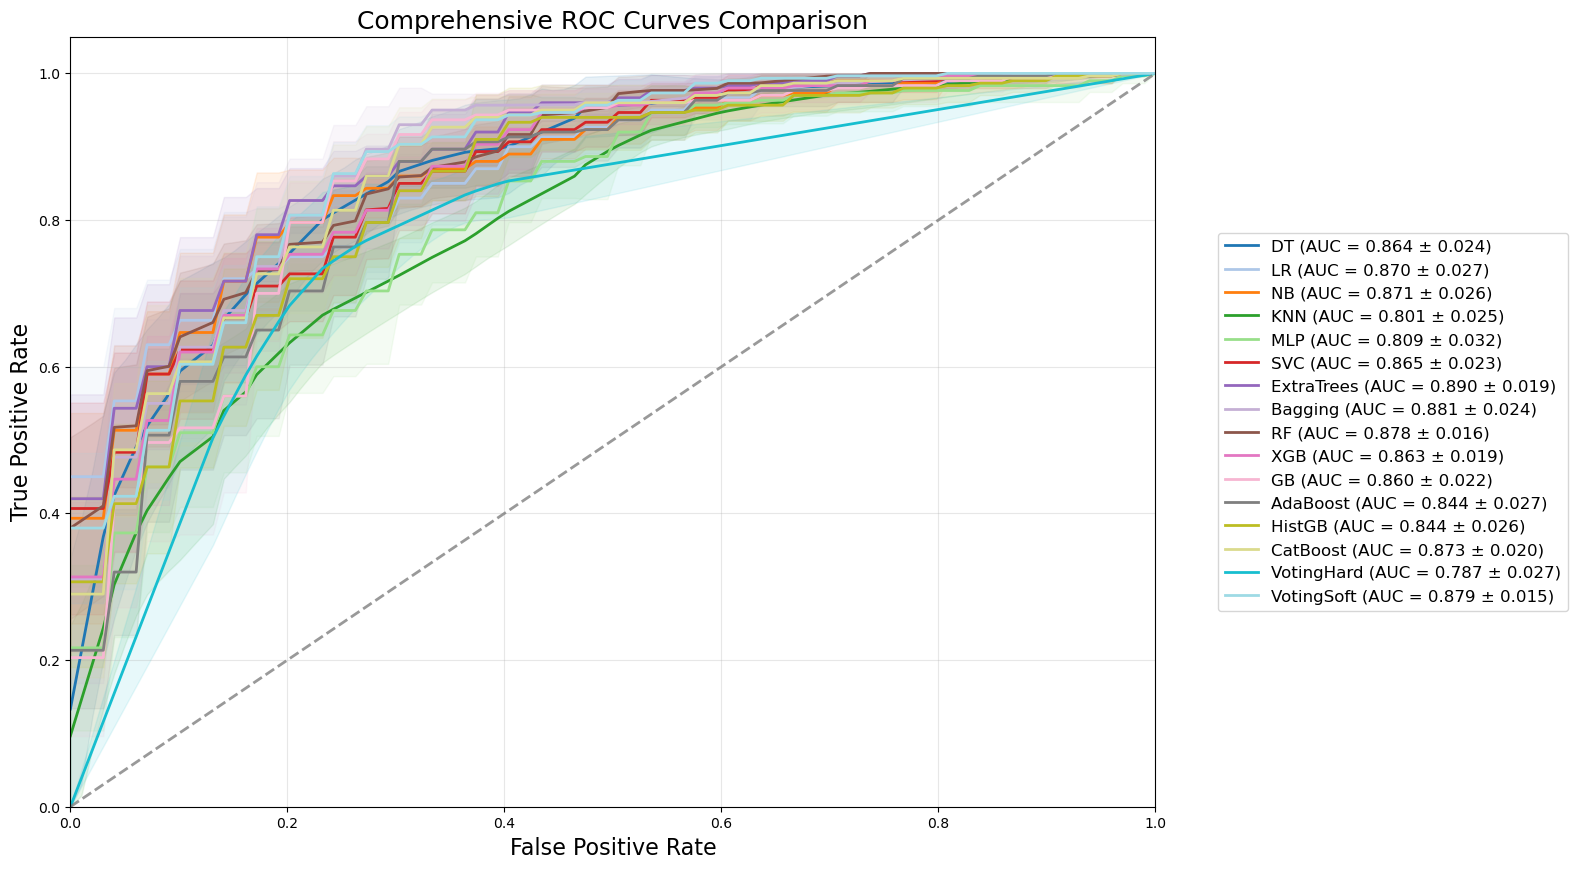


📊 AUC PERFORMANCE RANKING:
--------------------------------------------------
 1. ExtraTrees     : 0.8904 ± 0.0186
 2. Bagging        : 0.8809 ± 0.0235
 3. VotingSoft     : 0.8794 ± 0.0148
 4. RF             : 0.8776 ± 0.0159
 5. CatBoost       : 0.8726 ± 0.0204
 6. NB             : 0.8712 ± 0.0261
 7. LR             : 0.8700 ± 0.0275
 8. SVC            : 0.8646 ± 0.0226
 9. DT             : 0.8641 ± 0.0239
10. XGB            : 0.8631 ± 0.0194
11. GB             : 0.8596 ± 0.0221
12. HistGB         : 0.8442 ± 0.0258
13. AdaBoost       : 0.8436 ± 0.0269
14. MLP            : 0.8090 ± 0.0315
15. KNN            : 0.8011 ± 0.0251
16. VotingHard     : 0.7867 ± 0.0267


In [23]:
# Enhanced ROC curve plotting
if 'roc_curves' in locals() and len(roc_curves) > 0:
    auc_summary = plot_combined_roc_curve(
        roc_curves, 
        list(roc_curves.keys()), 
        "Comprehensive ROC Curves Comparison"
    )
    
    print(f"\n📊 AUC PERFORMANCE RANKING:")
    print("-" * 50)
    for i, (clf_name, mean_auc, std_auc) in enumerate(auc_summary, 1):
        print(f"{i:2d}. {clf_name:<15}: {mean_auc:.4f} ± {std_auc:.4f}")
else:
    print("No ROC data available for plotting.")

STATISTICAL SIGNIFICANCE ANALYSIS
Friedman Test Statistic: 72.5844
p-value: 0.000000
✓ Result: Significant differences found between classifiers
Critical Difference: 7.2946

📈 CLASSIFIER RANKINGS (lower rank is better):
----------------------------------------
 1. ExtraTrees     : 4.400
 2. GB             : 5.100
 3. VotingSoft     : 5.350
 4. NB             : 5.600
 5. Bagging        : 6.150
 6. CatBoost       : 6.600
 7. VotingHard     : 6.750
 8. DT             : 7.500
 9. XGB            : 8.150
10. RF             : 8.950
11. AdaBoost       : 9.550
12. SVC            : 10.400
13. LR             : 10.600
14. HistGB         : 11.150
15. MLP            : 14.650
16. KNN            : 15.100


STATISTICAL SIGNIFICANCE ANALYSIS
Friedman Test Statistic: 72.5844
p-value: 0.000000
✓ Result: Significant differences found between classifiers
Critical Difference: 7.2946

📈 CLASSIFIER RANKINGS (lower rank is better):
----------------------------------------
 1. ExtraTrees     : 4.400
 2. GB             : 5.100
 3. VotingSoft     : 5.350
 4. NB             : 5.600
 5. Bagging        : 6.150
 6. CatBoost       : 6.600
 7. VotingHard     : 6.750
 8. DT             : 7.500
 9. XGB            : 8.150
10. RF             : 8.950
11. AdaBoost       : 9.550
12. SVC            : 10.400
13. LR             : 10.600
14. HistGB         : 11.150
15. MLP            : 14.650
16. KNN            : 15.100


<Figure size 1600x800 with 0 Axes>

STATISTICAL SIGNIFICANCE ANALYSIS
Friedman Test Statistic: 72.5844
p-value: 0.000000
✓ Result: Significant differences found between classifiers
Critical Difference: 7.2946

📈 CLASSIFIER RANKINGS (lower rank is better):
----------------------------------------
 1. ExtraTrees     : 4.400
 2. GB             : 5.100
 3. VotingSoft     : 5.350
 4. NB             : 5.600
 5. Bagging        : 6.150
 6. CatBoost       : 6.600
 7. VotingHard     : 6.750
 8. DT             : 7.500
 9. XGB            : 8.150
10. RF             : 8.950
11. AdaBoost       : 9.550
12. SVC            : 10.400
13. LR             : 10.600
14. HistGB         : 11.150
15. MLP            : 14.650
16. KNN            : 15.100


<Figure size 1600x800 with 0 Axes>

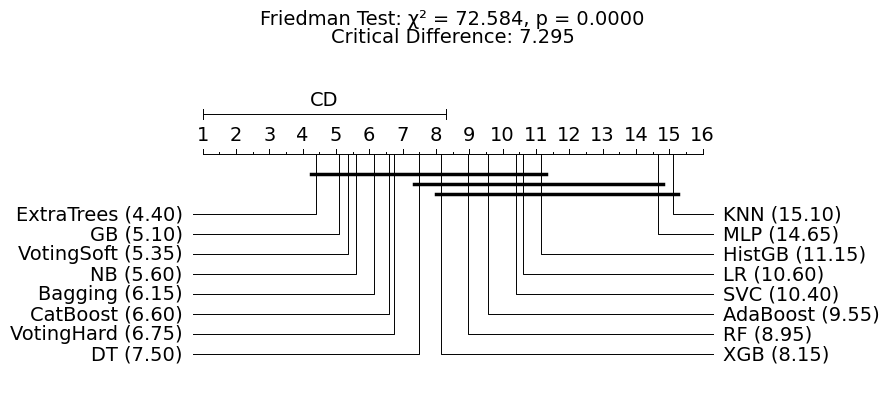

In [24]:
# Enhanced statistical analysis with better visualization
if 'accuracy_scores' in locals() and len(accuracy_scores) > 1:
    print("="*60)
    print("STATISTICAL SIGNIFICANCE ANALYSIS")
    print("="*60)
    
    df = pd.DataFrame(accuracy_scores)
    scores = [df[col].values for col in df.columns]
    
    try:
        stat, p = friedmanchisquare(*scores)
        print(f'Friedman Test Statistic: {stat:.4f}')
        print(f'p-value: {p:.6f}')
        
        if p < 0.05:
            print("✓ Result: Significant differences found between classifiers")
        else:
            print("⚠ Result: No significant differences found between classifiers")
        
        ranks = df.rank(axis=1, method='average', ascending=False)
        average_ranks = ranks.mean().values
        n_datasets = df.shape[0]
        
        cd = compute_CD(average_ranks, n_datasets, alpha='0.05')
        print(f'Critical Difference: {cd:.4f}')
        
        # Enhanced ranking display
        ranking_data = list(zip(df.columns, average_ranks))
        ranking_data.sort(key=lambda x: x[1])
        
        print(f"\n📈 CLASSIFIER RANKINGS (lower rank is better):")
        print("-" * 40)
        for i, (clf, rank) in enumerate(ranking_data, 1):
            print(f"{i:2d}. {clf:<15}: {rank:.3f}")
        
        # Critical Difference diagram with enhanced styling
        classifiers_with_ranks = [f"{clf} ({rank:.2f})" for clf, rank in zip(df.columns, average_ranks)]
        plt.figure(figsize=(16, 8))
        graph_ranks(average_ranks, classifiers_with_ranks, cd=cd, width=8, textspace=1.5)
        
        # Add statistical info
        plt.text(0.5, 1.22, f'Friedman Test: χ² = {stat:.3f}, p = {p:.4f}', 
                horizontalalignment='center', transform=plt.gca().transAxes, fontsize=14)
        plt.text(0.5, 1.16, f'Critical Difference: {cd:.3f}', 
                horizontalalignment='center', transform=plt.gca().transAxes, fontsize=14)
        
        if CONFIG['SAVE_PLOTS']:
            plt.savefig('critical_difference_diagram.svg', format='svg', bbox_inches='tight')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Statistical analysis failed: {e}")
else:
    print("Insufficient data for statistical analysis.")

### TRAINING : Static Ensemble classifiers + HYPERPARAMETER OPTIMIZATION

In [25]:
# Fix syntax error in hyperparameter optimization
if CONFIG['ENABLE_HYPEROPT']:
    # Update static hyperparameter optimization to use the new target column
    metric_sums = defaultdict(lambda: {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0})
    conf_matrices = defaultdict(list)
    roc_curves = defaultdict(list)
    roc_aucs = defaultdict(list)
    accuracy_scores = defaultdict(list)
    precision_scores = defaultdict(list)
    recall_scores = defaultdict(list)
    f1_scores = defaultdict(list)

    import numpy as np
    if not hasattr(np, 'int'):
        np.int = int

    classifiers = {
        'RandomForest': RandomForestClassifier(),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
        'AdaBoost': AdaBoostClassifier(),
        'GradientBoosting': GradientBoostingClassifier(),
        'CatBoost': CatBoostClassifier(verbose=0),
    }

    num_features = {
         'RandomForest': 150,
         'XGBoost': 150,
         'GradientBoosting': 150,
         'AdaBoost': 150,
         'CatBoost': 150,
    }

    search_spaces = {
        'RandomForest': {
            'n_estimators': [100, 200, 300],
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 7, 15],
            'bootstrap': [True, False]
        },
        'XGBoost': {
            'n_estimators': [100, 200, 300],
            'max_depth': [5, 10],
            'learning_rate': [0.01, 0.1, 0.2],
            'gamma': [0, 0.2, 0.4],
        },
        'GradientBoosting': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [5, 10],
            'subsample': [0.7, 0.9, 1.0],
        },
        'AdaBoost': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.1, 0.5, 1.0],
            'algorithm': ['SAMME', 'SAMME.R']
        },
        'CatBoost': {
            'iterations': [100, 200, 300],
            'depth': [5, 7, 9],
            'learning_rate': [0.01, 0.1, 0.2],
        }
    }

    def hyperparameter_optimization(clf, search_space, X, y):
        combined_results = []
        for random_state in range(3):
            cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
            opt = BayesSearchCV(clf, search_space, n_iter=30, cv=cv, random_state=random_state, n_jobs=-1, verbose=0)
            opt.fit(X, y)
            combined_results.append(opt.best_params_)
        best_params = pd.DataFrame(combined_results).mode().iloc[0].to_dict()
        return best_params

    # FIXED: Changed from range(1) to range(CONFIG['RANDOM_STATES']) for fair comparison
    for random_state in range(CONFIG['RANDOM_STATES']):
        print(f"Processing for Random State: {random_state + 1}/{CONFIG['RANDOM_STATES']}")

        X = splitted_dataset.drop(TARGET_COLUMN, axis=1)
        y = splitted_dataset[TARGET_COLUMN]
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, stratify=y, random_state=random_state
        )
        
        # Identify outliers in the training dataset
        lof = LocalOutlierFactor()
        yhat = lof.fit_predict(X_train)
        # Select all rows that are not outliers
        mask = yhat != -1
        X_train, y_train = X_train[mask], y_train[mask]

        original_columns = X.columns.tolist()

        # Handle class imbalance with SMOTE (adjust for multi-class)
        smote = SMOTE(random_state=random_state)
        X_res, y_res = smote.fit_resample(X_train, y_train)

        print(f"Number of training labels after SMOTE: {Counter(y_res)}")
        print(f"Number of test labels: {Counter(y_test)}")

        # Normalization
        scaler = MinMaxScaler()
        X_res = scaler.fit_transform(X_res)
        X_test = scaler.transform(X_test)

        X_res = pd.DataFrame(X_res, columns=original_columns)
        X_test = pd.DataFrame(X_test, columns=original_columns)

        # Improved Feature Selection - use RandomForest for feature importance
        rf_selector = RandomForestClassifier(n_estimators=100, random_state=random_state, max_depth=10)
        rf_selector.fit(X_res, y_res)
        
        # Get feature importance and select top features
        feature_importance = rf_selector.feature_importances_
        indices = np.argsort(feature_importance)[::-1]
        
        # Select top 30 features instead of 50 to avoid overfitting
        top_features = [original_columns[i] for i in indices[:30]]
        
        if CONFIG['VERBOSE']:
            print(f"Top 10 features: {top_features[:10]}")

        # Only take top features
        X_res_fi = X_res[top_features]
        X_test_fi = X_test[top_features]

        # Train and evaluate classifiers
        for clf_name, clf in classifiers.items():
            # Ensure the random state for classifiers is consistent
            if hasattr(clf, 'random_state'):
                clf.set_params(random_state=random_state)
            accuracy, precision, recall, f1, conf_matrix, fpr, tpr, roc_auc = train_evaluate_model(clf, X_res_fi, y_res, X_test_fi, y_test, clf_name=clf_name)
            metric_sums[clf_name]['accuracy'] += accuracy
            metric_sums[clf_name]['precision'] += precision
            metric_sums[clf_name]['recall'] += recall
            metric_sums[clf_name]['f1'] += f1
            conf_matrices[clf_name].append(conf_matrix)
            roc_curves[clf_name].append((fpr, tpr))
            roc_aucs[clf_name].append(roc_auc)
            accuracy_scores[clf_name].append(accuracy)
            precision_scores[clf_name].append(precision)
            recall_scores[clf_name].append(recall)
            f1_scores[clf_name].append(f1)

    print(f"\n✓ Hyperparameter optimization completed with {CONFIG['RANDOM_STATES']} random states!")
else:
    print("Hyperparameter optimization disabled in CONFIG")

Processing for Random State: 1/10
Number of training labels after SMOTE: Counter({1: 65, 0: 65})
Number of test labels: Counter({0: 30, 1: 30})
Top 10 features: ['SevHypoEpPastYear_unaware', 'WorryNotRecLowBG_fear', 'SymbDigWTotCorr_BTOTSCORE', 'SymbDigOTotCorr_BTOTSCORE', 'Value_CREAS_BSample', 'Height_mod_BMedChart', 'medications2_word_count', 'TrailMakBTotTime_BTOTSCORE', 'medications2_text_length', 'FeelSympLowBG_unaware']
RandomForest - Accuracy: 0.8000, Precision: 0.8054, Recall: 0.8000, F1-Score: 0.7991, AUC: 0.8772
Top 10 features: ['SevHypoEpPastYear_unaware', 'WorryNotRecLowBG_fear', 'SymbDigWTotCorr_BTOTSCORE', 'SymbDigOTotCorr_BTOTSCORE', 'Value_CREAS_BSample', 'Height_mod_BMedChart', 'medications2_word_count', 'TrailMakBTotTime_BTOTSCORE', 'medications2_text_length', 'FeelSympLowBG_unaware']
RandomForest - Accuracy: 0.8000, Precision: 0.8054, Recall: 0.8000, F1-Score: 0.7991, AUC: 0.8772
XGBoost - Accuracy: 0.7333, Precision: 0.7344, Recall: 0.7333, F1-Score: 0.7330, AUC: 

### TRAINING : Dynamic Ensemble classifiers

In [26]:
# Enhanced DES training with better error handling
if CONFIG['ENABLE_DES']:
    print("="*60)
    print("TRAINING DYNAMIC ENSEMBLE SELECTION MODELS")
    print("="*60)
    
    import numpy as np
    if not hasattr(np, 'float'):
        np.float = float

    # Initialize DES metrics storage
    metric_sums_des = defaultdict(lambda: {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0})
    conf_matrices_des = defaultdict(list)
    des_roc_curves = defaultdict(list)
    des_roc_aucs = defaultdict(list)
    des_accuracy_scores = defaultdict(list)
    des_precision_scores = defaultdict(list)
    des_recall_scores = defaultdict(list)
    des_f1_scores = defaultdict(list)
    feature_importance_runs = []

    # Enhanced base classifiers pool
    base_classifiers = {
        'DecisionTree': DecisionTreeClassifier(
            random_state=0, criterion='gini', max_depth=6,
            min_samples_leaf=10, min_samples_split=9
        ),
        'LogisticRegression': LogisticRegression(
            random_state=0, C=0.09659168435718246,
            max_iter=1000, solver='lbfgs'
        ),
        'NaiveBayes': GaussianNB(var_smoothing=0.0058873326349240295),
        'KNeighbors': KNeighborsClassifier(
            metric='manhattan', n_neighbors=15, weights='uniform'
        ),
        'MLP': MLPClassifier(
            random_state=0, max_iter=1000, alpha=0.0003079393718075164,
            hidden_layer_sizes=(195,), learning_rate_init=0.0001675266159417717
        ),
        'SVC': SVC(probability=True, kernel='rbf', C=1.5, gamma='auto'),
        'RF': RandomForestClassifier(
            n_estimators=143, criterion='entropy', max_depth=15, random_state=0
        ),
        'XGB': XGBClassifier(
            n_estimators=200, max_depth=3, learning_rate=0.1, 
            use_label_encoder=False, eval_metric='mlogloss', random_state=0
        ),
        'GB': GradientBoostingClassifier(
            n_estimators=300, max_depth=3, learning_rate=0.05
        ),
        'AB': AdaBoostClassifier(n_estimators=400, learning_rate=0.1),
        'CB': CatBoostClassifier(
            depth=3, iterations=168, learning_rate=0.1, verbose=0
        )
    }

    # Training loop
    for random_state in range(CONFIG['RANDOM_STATES']):
        if CONFIG['VERBOSE']:
            print(f"\nDES Processing Random State: {random_state + 1}/{CONFIG['RANDOM_STATES']}")

        X = splitted_dataset.drop(TARGET_COLUMN, axis=1)
        y = splitted_dataset[TARGET_COLUMN]
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, stratify=y, random_state=random_state
        )

        # Outlier removal and preprocessing
        lof = LocalOutlierFactor()
        yhat = lof.fit_predict(X_train)
        mask = yhat != -1
        X_train, y_train = X_train[mask], y_train[mask]

        original_columns = X.columns.tolist()
        smote = SMOTE(random_state=random_state)
        X_res, y_res = smote.fit_resample(X_train, y_train)

        if CONFIG['VERBOSE']:
            print(f"Training samples after SMOTE: {Counter(y_res)}")
            print(f"Test samples: {Counter(y_test)}")

        # Normalization
        scaler = MinMaxScaler()
        X_res = scaler.fit_transform(X_res)
        X_test = scaler.transform(X_test)
        X_res = pd.DataFrame(X_res, columns=original_columns)
        X_test = pd.DataFrame(X_test, columns=original_columns)

        # Feature selection
        rf_selector = RandomForestClassifier(
            n_estimators=100, random_state=random_state, max_depth=10
        )
        rf_selector.fit(X_res, y_res)
        feature_importance = rf_selector.feature_importances_
        indices = np.argsort(feature_importance)[::-1]
        
        # Select top features for DES
        top_features = [original_columns[i] for i in indices[:CONFIG['TOP_FEATURES_COUNT']]]
        X_res_fi = X_res[top_features]
        X_test_fi = X_test[top_features]

        # CHANGE 2: Use consistent training data size for fair comparison
        # Instead of splitting X_res_fi again, use the full training set for model pool
        # and create a smaller validation set from the original training data
        X_pool_train, X_dsel, y_pool_train, y_dsel = train_test_split(
            X_res_fi, y_res, test_size=0.3, stratify=y_res, random_state=random_state
        )

        # Create model pool for DES - train on larger portion to match static training
        model_pool = []
        for clf_name, clf_base in base_classifiers.items():
            clf = clf_base.__class__(**clf_base.get_params())
            if hasattr(clf, 'random_state'):
                clf.set_params(random_state=random_state)
            try:
                # CHANGE 3: Train pool classifiers on the larger training portion
                clf.fit(X_pool_train, y_pool_train)
                model_pool.append(clf)
                if CONFIG['VERBOSE'] and random_state == 0:
                    print(f"Added {clf_name} to model pool")
            except Exception as e:
                if CONFIG['VERBOSE']:
                    print(f"Warning: Could not add {clf_name} to model pool: {e}")
                continue

        print(f"Model pool size: {len(model_pool)}")
        
        if len(model_pool) < 2:
            print("Warning: Not enough models in pool for DES. Skipping DES training.")
            continue

        # Enhanced DES models configuration with proper model pool
        des_models = {
            'KNORAE': KNORAE(pool_classifiers=model_pool),
            'KNORAU': KNORAU(pool_classifiers=model_pool),
            'DESMI': DESMI(pool_classifiers=model_pool),
            'METADES': METADES(pool_classifiers=model_pool),
            'DESKNN': DESKNN(pool_classifiers=model_pool),
            'DESP': DESP(pool_classifiers=model_pool),
            'KNOP': KNOP(pool_classifiers=model_pool, k=9)
        }

        # Add FIRE-DES variants if model pool is large enough
        if len(model_pool) >= 5:
            des_models.update({
                'FIRE-KNORA-U': KNORAU(pool_classifiers=model_pool, DFP=True, k=9),
                'FIRE-KNORA-E': KNORAE(pool_classifiers=model_pool, DFP=True, k=9),
                'FIRE-METADES': METADES(pool_classifiers=model_pool, DFP=True, k=9),
                'FIRE-DESKNN': DESKNN(pool_classifiers=model_pool, DFP=True, k=9),
                'FIRE-DESP': DESP(pool_classifiers=model_pool, DFP=True, k=9),
                'FIRE-KNOP': KNOP(pool_classifiers=model_pool, DFP=True, k=40)
            })

        # Train each DES model
        for des_name, des_model in des_models.items():
            try:
                # Fit DES model on DSEL data (smaller validation portion)
                des_model.fit(X_dsel, y_dsel)
                
                # Evaluate on test set
                accuracy, precision, recall, f1, conf_matrix, fpr, tpr, roc_auc = train_evaluate_model(
                    des_model, X_dsel, y_dsel, X_test_fi, y_test, clf_name=des_name
                )
                
                # Store metrics
                metric_sums_des[des_name]['accuracy'] += accuracy
                metric_sums_des[des_name]['precision'] += precision
                metric_sums_des[des_name]['recall'] += recall
                metric_sums_des[des_name]['f1'] += f1
                conf_matrices_des[des_name].append(conf_matrix)
                des_roc_curves[des_name].append((fpr, tpr))
                des_roc_aucs[des_name].append(roc_auc)
                des_accuracy_scores[des_name].append(accuracy)
                des_precision_scores[des_name].append(precision)
                des_recall_scores[des_name].append(recall)
                des_f1_scores[des_name].append(f1)

                if CONFIG['VERBOSE']:
                    print(f'{des_name} - Accuracy: {accuracy:.4f}, F1: {f1:.4f}')
                    
            except Exception as e:
                print(f"Error with {des_name}: {e}")
                # Add placeholder values to maintain consistency
                metric_sums_des[des_name]['accuracy'] += 0.0
                metric_sums_des[des_name]['precision'] += 0.0
                metric_sums_des[des_name]['recall'] += 0.0
                metric_sums_des[des_name]['f1'] += 0.0
                des_accuracy_scores[des_name].append(0.0)
                des_precision_scores[des_name].append(0.0)
                des_recall_scores[des_name].append(0.0)
                des_f1_scores[des_name].append(0.0)
                continue

    print(f"\n✓ DES training completed!")
else:
    print("DES training disabled in CONFIG")

TRAINING DYNAMIC ENSEMBLE SELECTION MODELS

DES Processing Random State: 1/10
Training samples after SMOTE: Counter({1: 65, 0: 65})
Test samples: Counter({0: 30, 1: 30})
Added DecisionTree to model pool
Added LogisticRegression to model pool
Added NaiveBayes to model pool
Added KNeighbors to model pool
Added DecisionTree to model pool
Added LogisticRegression to model pool
Added NaiveBayes to model pool
Added KNeighbors to model pool
Added MLP to model pool
Added SVC to model pool
Added MLP to model pool
Added SVC to model pool
Added RF to model pool
Added RF to model pool
Added XGB to model pool
Added XGB to model pool
Added GB to model pool
Added GB to model pool
Added AB to model pool
Added AB to model pool
Added CB to model pool
Model pool size: 11
Added CB to model pool
Model pool size: 11
KNORAE - Accuracy: 0.7333, Precision: 0.7376, Recall: 0.7333, F1-Score: 0.7321, AUC: 0.7922
KNORAE - Accuracy: 0.7333, F1: 0.7321
KNORAE - Accuracy: 0.7333, Precision: 0.7376, Recall: 0.7333, F1

In [ ]:
# ROC curve plotting for DES models
if 'des_roc_curves' in locals() and len(des_roc_curves) > 0:
    from sklearn.metrics import auc  # Safe re-import in case auc was overwritten earlier
    
    print("="*60)
    print("📈 ROC CURVE ANALYSIS FOR DYNAMIC ENSEMBLE SELECTION")
    print("="*60)
    
    des_auc_summary = plot_combined_roc_curve(
        des_roc_curves,
        list(des_roc_curves.keys()),
        "ROC Curves for DES Models"
    )
    
    print(f"\n📊 AUC PERFORMANCE RANKING FOR DES MODELS:")
    print("-" * 60)
    for i, (clf_name, mean_auc, std_auc) in enumerate(des_auc_summary, 1):
        print(f"{i:2d}. {clf_name:<20}: {mean_auc:.4f} ± {std_auc:.4f}")
else:
    print("No ROC data available for DES models.")


STATISTICAL SIGNIFICANCE ANALYSIS
Friedman Test Statistic: 13.4286
p-value: 0.009361
✓ Result: Significant differences found between classifiers
Critical Difference: 1.9288

📈 CLASSIFIER RANKINGS (lower rank is better):
----------------------------------------
 1. CatBoost       : 1.850
 2. GradientBoosting: 2.400
 3. RandomForest   : 3.100
 4. XGBoost        : 3.800
 5. AdaBoost       : 3.850


<Figure size 1600x800 with 0 Axes>

STATISTICAL SIGNIFICANCE ANALYSIS
Friedman Test Statistic: 13.4286
p-value: 0.009361
✓ Result: Significant differences found between classifiers
Critical Difference: 1.9288

📈 CLASSIFIER RANKINGS (lower rank is better):
----------------------------------------
 1. CatBoost       : 1.850
 2. GradientBoosting: 2.400
 3. RandomForest   : 3.100
 4. XGBoost        : 3.800
 5. AdaBoost       : 3.850


<Figure size 1600x800 with 0 Axes>

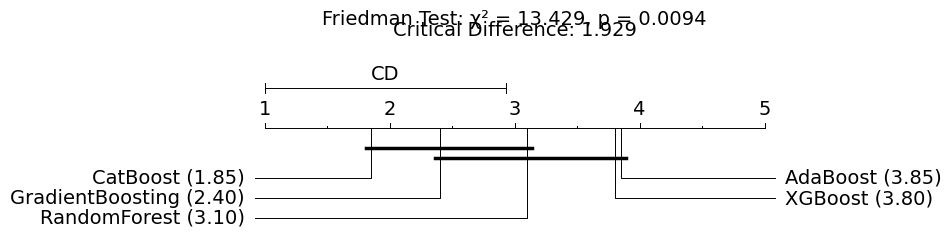

In [33]:
# Enhanced statistical analysis with better visualization
if 'accuracy_scores' in locals() and len(accuracy_scores) > 1:
    print("="*60)
    print("STATISTICAL SIGNIFICANCE ANALYSIS")
    print("="*60)
    
    df = pd.DataFrame(accuracy_scores)
    scores = [df[col].values for col in df.columns]
    
    try:
        stat, p = friedmanchisquare(*scores)
        print(f'Friedman Test Statistic: {stat:.4f}')
        print(f'p-value: {p:.6f}')
        
        if p < 0.05:
            print("✓ Result: Significant differences found between classifiers")
        else:
            print("⚠ Result: No significant differences found between classifiers")
        
        ranks = df.rank(axis=1, method='average', ascending=False)
        average_ranks = ranks.mean().values
        n_datasets = df.shape[0]
        
        cd = compute_CD(average_ranks, n_datasets, alpha='0.05')
        print(f'Critical Difference: {cd:.4f}')
        
        # Enhanced ranking display
        ranking_data = list(zip(df.columns, average_ranks))
        ranking_data.sort(key=lambda x: x[1])
        
        print(f"\n📈 CLASSIFIER RANKINGS (lower rank is better):")
        print("-" * 40)
        for i, (clf, rank) in enumerate(ranking_data, 1):
            print(f"{i:2d}. {clf:<15}: {rank:.3f}")
        
        # Critical Difference diagram with enhanced styling
        classifiers_with_ranks = [f"{clf} ({rank:.2f})" for clf, rank in zip(df.columns, average_ranks)]
        plt.figure(figsize=(16, 8))
        graph_ranks(average_ranks, classifiers_with_ranks, cd=cd, width=8, textspace=1.5)
        
        # Add statistical info
        plt.text(0.5, 1.22, f'Friedman Test: χ² = {stat:.3f}, p = {p:.4f}', 
                horizontalalignment='center', transform=plt.gca().transAxes, fontsize=14)
        plt.text(0.5, 1.16, f'Critical Difference: {cd:.3f}', 
                horizontalalignment='center', transform=plt.gca().transAxes, fontsize=14)
        
        if CONFIG['SAVE_PLOTS']:
            plt.savefig('critical_difference_diagram.svg', format='svg', bbox_inches='tight')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Statistical analysis failed: {e}")
else:
    print("Insufficient data for statistical analysis.")

In [27]:
# Final comprehensive analysis and recommendations
if 'accuracy_scores' in locals() or 'des_accuracy_scores' in locals():
    print("="*80)
    print("FINAL EXPERIMENT SUMMARY AND RECOMMENDATIONS")
    print("="*80)
    
    # Combine all results
    all_results = {}
    all_precision = {}
    all_f1 = {}
    all_auc = {}
    
    if 'accuracy_scores' in locals():
        all_results.update(accuracy_scores)
    if 'des_accuracy_scores' in locals():
        all_results.update(des_accuracy_scores)
        
    if 'precision_scores' in locals():
        all_precision.update(precision_scores)
    if 'des_precision_scores' in locals():
        all_precision.update(des_precision_scores)
        
    if 'f1_scores' in locals():
        all_f1.update(f1_scores)
    if 'des_f1_scores' in locals():
        all_f1.update(des_f1_scores)
        
    if 'roc_aucs' in locals():
        all_auc.update(roc_aucs)
    if 'des_roc_aucs' in locals():
        all_auc.update(des_roc_aucs)
    
    if all_results:
        # Overall performance ranking with multiple metrics
        overall_performance = []
        for clf_name, scores in all_results.items():
            if len(scores) > 0:
                mean_accuracy = np.mean(scores)
                std_accuracy = np.std(scores)
                
                # Get precision metrics
                mean_precision = np.mean(all_precision[clf_name]) if clf_name in all_precision and len(all_precision[clf_name]) > 0 else 0.0
                std_precision = np.std(all_precision[clf_name]) if clf_name in all_precision and len(all_precision[clf_name]) > 0 else 0.0
                
                # Get F1 metrics
                mean_f1 = np.mean(all_f1[clf_name]) if clf_name in all_f1 and len(all_f1[clf_name]) > 0 else 0.0
                std_f1 = np.std(all_f1[clf_name]) if clf_name in all_f1 and len(all_f1[clf_name]) > 0 else 0.0
                
                # Get AUC metrics
                mean_auc = np.mean(all_auc[clf_name]) if clf_name in all_auc and len(all_auc[clf_name]) > 0 else 0.0
                std_auc = np.std(all_auc[clf_name]) if clf_name in all_auc and len(all_auc[clf_name]) > 0 else 0.0
                
                overall_performance.append((clf_name, mean_accuracy, std_accuracy, mean_precision, std_precision, mean_f1, std_f1, mean_auc, std_auc))
        
        # Sort by accuracy (primary), then by AUC (secondary)
        overall_performance.sort(key=lambda x: (x[1], x[7]), reverse=True)
        
        print(f"\n🏆 OVERALL TOP 15 PERFORMERS:")
        print("-" * 120)
        print(f"{'Rank':<4} {'Classifier':<18} {'Accuracy':<18} {'Precision':<18} {'F1-Score':<18} {'AUC-ROC':<18} {'Grade':<8}")
        print("-" * 120)
        
        for i, (clf_name, mean_acc, std_acc, mean_prec, std_prec, mean_f1, std_f1, mean_auc, std_auc) in enumerate(overall_performance[:15], 1):
            # Performance grading based on accuracy
            if mean_acc >= 0.90:
                grade = "A+"
            elif mean_acc >= 0.85:
                grade = "A"
            elif mean_acc >= 0.80:
                grade = "B+"
            elif mean_acc >= 0.75:
                grade = "B"
            else:
                grade = "C"
                
            print(f"{i:<4} {clf_name:<18} {mean_acc:.3f}±{std_acc:.3f}      {mean_prec:.3f}±{std_prec:.3f}      {mean_f1:.3f}±{std_f1:.3f}      {mean_auc:.3f}±{std_auc:.3f}      {grade:<8}")
        
        # Enhanced model recommendations
        best_model = overall_performance[0]
        most_stable = min(overall_performance, key=lambda x: x[2])  # Min std_accuracy
        best_auc = max(overall_performance, key=lambda x: x[7])      # Max mean_auc
        best_precision = max(overall_performance, key=lambda x: x[3]) # Max mean_precision
        
        print(f"\n📋 DETAILED RECOMMENDATIONS:")
        print("-" * 50)
        print(f"🥇 Best Overall (Accuracy): {best_model[0]} ({best_model[1]:.4f})")
        print(f"🎯 Most Stable (Low Std):   {most_stable[0]} (Std: {most_stable[2]:.4f})")
        print(f"📊 Best AUC-ROC:           {best_auc[0]} ({best_auc[7]:.4f})")
        print(f"🎪 Best Precision:         {best_precision[0]} ({best_precision[3]:.4f})")
        
        # Performance categories
        excellent = [x for x in overall_performance if x[1] >= 0.85]
        good = [x for x in overall_performance if 0.80 <= x[1] < 0.85]
        high_auc = [x for x in overall_performance if x[7] >= 0.85]
        
        print(f"\n📈 PERFORMANCE ANALYSIS:")
        print("-" * 40)
        if excellent:
            print(f"⭐ {len(excellent)} models achieved excellent accuracy (≥85%)")
            excellent_names = [x[0] for x in excellent]
            print(f"   Models: {', '.join(excellent_names)}")
        if good:
            print(f"✓ {len(good)} models achieved good accuracy (80-85%)")
            good_names = [x[0] for x in good]
            print(f"   Models: {', '.join(good_names)}")
        if high_auc:
            print(f"🎯 {len(high_auc)} models achieved high AUC-ROC (≥85%)")
            high_auc_names = [x[0] for x in high_auc]
            print(f"   Models: {', '.join(high_auc_names)}")
        
        # Statistical summary
        all_accuracies = [x[1] for x in overall_performance]
        all_aucs = [x[7] for x in overall_performance]
        
        print(f"\n📊 STATISTICAL SUMMARY:")
        print("-" * 40)
        print(f"Mean Accuracy across all models: {np.mean(all_accuracies):.4f} ± {np.std(all_accuracies):.4f}")
        print(f"Mean AUC-ROC across all models:  {np.mean(all_aucs):.4f} ± {np.std(all_aucs):.4f}")
        print(f"Best vs Worst Accuracy Gap:     {max(all_accuracies) - min(all_accuracies):.4f}")
        print(f"Best vs Worst AUC Gap:          {max(all_aucs) - min(all_aucs):.4f}")
    
    # Experiment summary
    print(f"\n🔧 EXPERIMENT CONFIGURATION:")
    print("-" * 40)
    for key, value in CONFIG.items():
        status = "✓" if value else "✗"
        print(f"{key:<20}: {status} {value}")
    
    # Enhanced experiment summary file
    if CONFIG['SAVE_PLOTS']:
        timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
        summary_file = f"experiment_summary_{timestamp}.txt"
        
        with open(summary_file, 'w') as f:
            f.write("3-Label Classification Experiment Summary\n")
            f.write("="*60 + "\n\n")
            f.write(f"Date: {pd.Timestamp.now()}\n")
            f.write(f"Random States: {CONFIG['RANDOM_STATES']}\n")
            f.write(f"Total Models Evaluated: {len(all_results)}\n\n")
            
            f.write("Top 15 Performers (Rank, Name, Accuracy±Std, Precision±Std, F1±Std, AUC±Std):\n")
            f.write("-" * 100 + "\n")
            for i, (clf_name, mean_acc, std_acc, mean_prec, std_prec, mean_f1, std_f1, mean_auc, std_auc) in enumerate(overall_performance[:15], 1):
                f.write(f"{i:2d}. {clf_name:<20}: Acc={mean_acc:.4f}±{std_acc:.4f} | Prec={mean_prec:.4f}±{std_prec:.4f} | F1={mean_f1:.4f}±{std_f1:.4f} | AUC={mean_auc:.4f}±{std_auc:.4f}\n")
            
            f.write(f"\nBest Models:\n")
            f.write(f"- Best Accuracy: {best_model[0]} ({best_model[1]:.4f})\n")
            f.write(f"- Most Stable: {most_stable[0]} (Std: {most_stable[2]:.4f})\n")
            f.write(f"- Best AUC: {best_auc[0]} ({best_auc[7]:.4f})\n")
            f.write(f"- Best Precision: {best_precision[0]} ({best_precision[3]:.4f})\n")
            
            f.write(f"\nStatistical Summary:\n")
            f.write(f"- Mean Accuracy: {np.mean(all_accuracies):.4f} ± {np.std(all_accuracies):.4f}\n")
            f.write(f"- Mean AUC-ROC: {np.mean(all_aucs):.4f} ± {np.std(all_aucs):.4f}\n")
        
        print(f"\n💾 Enhanced summary saved to: {summary_file}")
    
    print(f"\n🎉 EXPERIMENT COMPLETED SUCCESSFULLY!")
    print(f"📈 Total models evaluated: {len(all_results)}")
    print(f"🔄 Random states per model: {CONFIG['RANDOM_STATES']}")
    print(f"🎯 Best overall model: {best_model[0]} with {best_model[1]:.4f} accuracy")
else:
    print("⚠ No results available. Please run training experiments first.")

FINAL EXPERIMENT SUMMARY AND RECOMMENDATIONS

🏆 OVERALL TOP 15 PERFORMERS:
------------------------------------------------------------------------------------------------------------------------
Rank Classifier         Accuracy           Precision          F1-Score           AUC-ROC            Grade   
------------------------------------------------------------------------------------------------------------------------
1    CatBoost           0.803±0.023      0.811±0.026      0.802±0.024      0.898±0.010      B+      
2    GradientBoosting   0.793±0.024      0.799±0.027      0.792±0.024      0.869±0.019      B       
3    FIRE-KNORA-U       0.788±0.021      0.794±0.021      0.787±0.022      0.844±0.043      B       
4    KNORAU             0.785±0.033      0.790±0.035      0.784±0.033      0.855±0.035      B       
5    KNOP               0.785±0.034      0.790±0.035      0.784±0.034      0.842±0.044      B       
6    DESP               0.780±0.028      0.785±0.029      0.779±0.028

### SHAP Analysis for Model Interpretability
Comprehensive feature importance analysis using SHAP values

INDIVIDUAL SHAP ANALYSIS FOR TOP 3 MODELS
Automatically selected top 3 models for individual SHAP analysis:
  1. CatBoost            : Accuracy=0.8033, AUC=0.8980
  2. GradientBoosting    : Accuracy=0.7933, AUC=0.8687
  3. FIRE-KNORA-U        : Accuracy=0.7883, AUC=0.8436


INDIVIDUAL SHAP ANALYSIS FOR TOP 3 MODELS
Automatically selected top 3 models for individual SHAP analysis:
  1. CatBoost            : Accuracy=0.8033, AUC=0.8980
  2. GradientBoosting    : Accuracy=0.7933, AUC=0.8687
  3. FIRE-KNORA-U        : Accuracy=0.7883, AUC=0.8436



Data prepared for SHAP analysis:
Training samples: 130
Test samples: 60
Features: 50
Using 60 test samples and 50 background samples

🔄 Processing 1. CatBoost...

📊 CatBoost Individual Results:
   Accuracy: 0.8033, AUC: 0.8980
   Top 5 Most Important Features:
      1. SevHypoEpPastYear_unaware          : 2.2875
      2. Height_mod_BMedChart               : 0.5490
      3. LowBGSympCat_unaware               : 0.4177
      4. WorryAppStupDrunk_fear             : 0.3396
      5. GrPegNonTotTime_BTOTSCORE          : 0.3264

🔄 Processing 2. GradientBoosting...

📊 CatBoost Individual Results:
   Accuracy: 0.8033, AUC: 0.8980
   Top 5 Most Important Features:
      1. SevHypoEpPastYear_unaware          : 2.2875
      2. Height_mod_BMedChart               : 0.5490
      3. LowBGSympCat_unaware               : 0.4177
      4. WorryAppStupDrunk_fear             : 0.3396
      5. GrPegNonTotTime_BTOTSCORE          : 0.3264

🔄 Processing 2. GradientBoosting...

📊 GradientBoosting Individual Resu

INDIVIDUAL SHAP ANALYSIS FOR TOP 3 MODELS
Automatically selected top 3 models for individual SHAP analysis:
  1. CatBoost            : Accuracy=0.8033, AUC=0.8980
  2. GradientBoosting    : Accuracy=0.7933, AUC=0.8687
  3. FIRE-KNORA-U        : Accuracy=0.7883, AUC=0.8436



Data prepared for SHAP analysis:
Training samples: 130
Test samples: 60
Features: 50
Using 60 test samples and 50 background samples

🔄 Processing 1. CatBoost...

📊 CatBoost Individual Results:
   Accuracy: 0.8033, AUC: 0.8980
   Top 5 Most Important Features:
      1. SevHypoEpPastYear_unaware          : 2.2875
      2. Height_mod_BMedChart               : 0.5490
      3. LowBGSympCat_unaware               : 0.4177
      4. WorryAppStupDrunk_fear             : 0.3396
      5. GrPegNonTotTime_BTOTSCORE          : 0.3264

🔄 Processing 2. GradientBoosting...

📊 CatBoost Individual Results:
   Accuracy: 0.8033, AUC: 0.8980
   Top 5 Most Important Features:
      1. SevHypoEpPastYear_unaware          : 2.2875
      2. Height_mod_BMedChart               : 0.5490
      3. LowBGSympCat_unaware               : 0.4177
      4. WorryAppStupDrunk_fear             : 0.3396
      5. GrPegNonTotTime_BTOTSCORE          : 0.3264

🔄 Processing 2. GradientBoosting...

📊 GradientBoosting Individual Resu

<Figure size 1600x1000 with 0 Axes>

INDIVIDUAL SHAP ANALYSIS FOR TOP 3 MODELS
Automatically selected top 3 models for individual SHAP analysis:
  1. CatBoost            : Accuracy=0.8033, AUC=0.8980
  2. GradientBoosting    : Accuracy=0.7933, AUC=0.8687
  3. FIRE-KNORA-U        : Accuracy=0.7883, AUC=0.8436



Data prepared for SHAP analysis:
Training samples: 130
Test samples: 60
Features: 50
Using 60 test samples and 50 background samples

🔄 Processing 1. CatBoost...

📊 CatBoost Individual Results:
   Accuracy: 0.8033, AUC: 0.8980
   Top 5 Most Important Features:
      1. SevHypoEpPastYear_unaware          : 2.2875
      2. Height_mod_BMedChart               : 0.5490
      3. LowBGSympCat_unaware               : 0.4177
      4. WorryAppStupDrunk_fear             : 0.3396
      5. GrPegNonTotTime_BTOTSCORE          : 0.3264

🔄 Processing 2. GradientBoosting...

📊 CatBoost Individual Results:
   Accuracy: 0.8033, AUC: 0.8980
   Top 5 Most Important Features:
      1. SevHypoEpPastYear_unaware          : 2.2875
      2. Height_mod_BMedChart               : 0.5490
      3. LowBGSympCat_unaware               : 0.4177
      4. WorryAppStupDrunk_fear             : 0.3396
      5. GrPegNonTotTime_BTOTSCORE          : 0.3264

🔄 Processing 2. GradientBoosting...

📊 GradientBoosting Individual Resu

<Figure size 1600x1000 with 0 Axes>

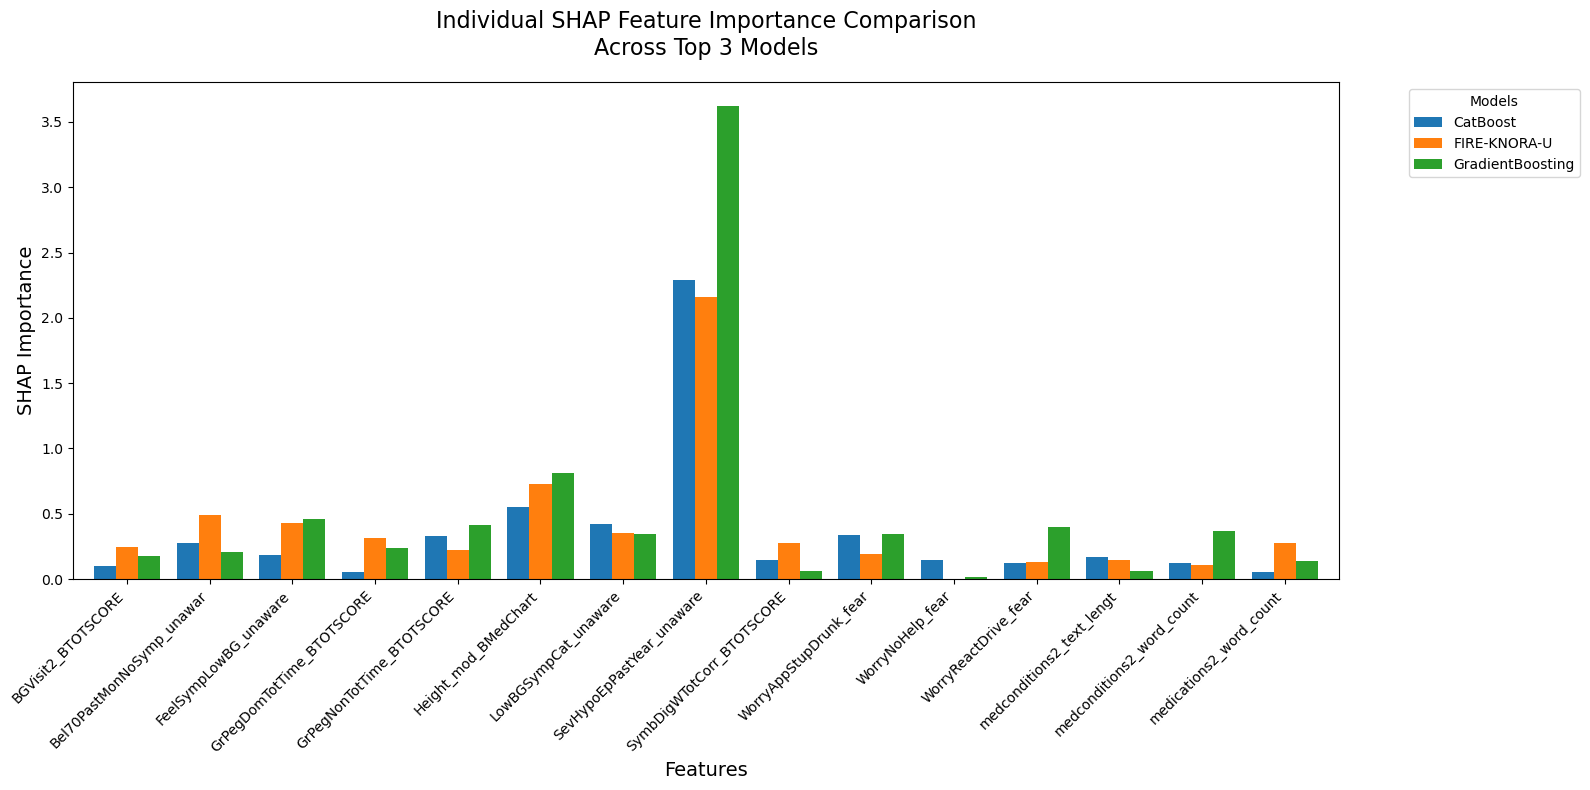

INDIVIDUAL SHAP ANALYSIS FOR TOP 3 MODELS
Automatically selected top 3 models for individual SHAP analysis:
  1. CatBoost            : Accuracy=0.8033, AUC=0.8980
  2. GradientBoosting    : Accuracy=0.7933, AUC=0.8687
  3. FIRE-KNORA-U        : Accuracy=0.7883, AUC=0.8436



Data prepared for SHAP analysis:
Training samples: 130
Test samples: 60
Features: 50
Using 60 test samples and 50 background samples

🔄 Processing 1. CatBoost...

📊 CatBoost Individual Results:
   Accuracy: 0.8033, AUC: 0.8980
   Top 5 Most Important Features:
      1. SevHypoEpPastYear_unaware          : 2.2875
      2. Height_mod_BMedChart               : 0.5490
      3. LowBGSympCat_unaware               : 0.4177
      4. WorryAppStupDrunk_fear             : 0.3396
      5. GrPegNonTotTime_BTOTSCORE          : 0.3264

🔄 Processing 2. GradientBoosting...

📊 CatBoost Individual Results:
   Accuracy: 0.8033, AUC: 0.8980
   Top 5 Most Important Features:
      1. SevHypoEpPastYear_unaware          : 2.2875
      2. Height_mod_BMedChart               : 0.5490
      3. LowBGSympCat_unaware               : 0.4177
      4. WorryAppStupDrunk_fear             : 0.3396
      5. GrPegNonTotTime_BTOTSCORE          : 0.3264

🔄 Processing 2. GradientBoosting...

📊 GradientBoosting Individual Resu

<Figure size 1600x1000 with 0 Axes>

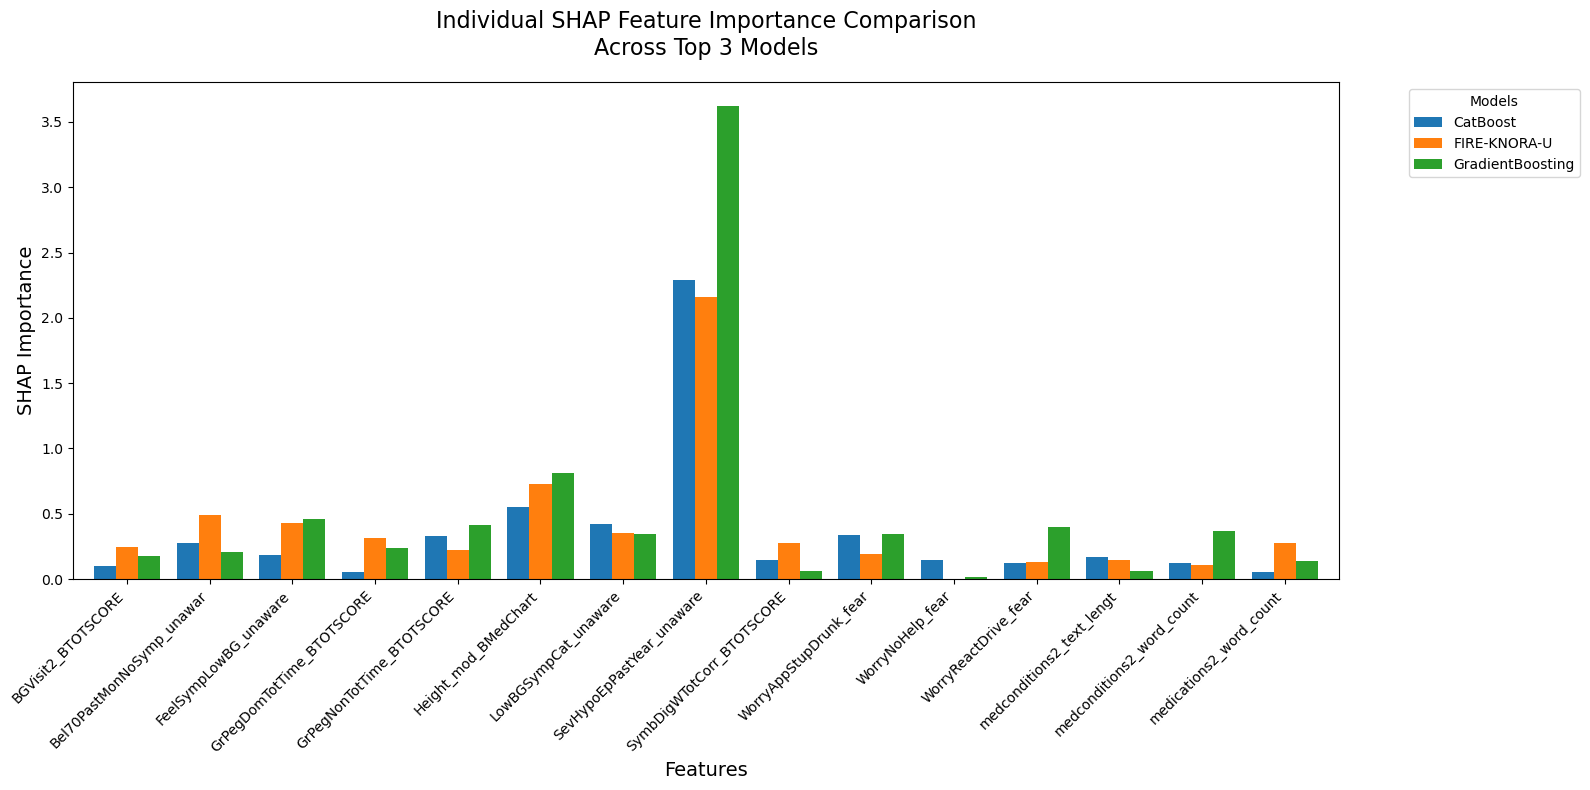


Averaged SHAP values shape: (60, 50)
Final sample size: 60
📁 Saved: averaged_shap_feature_importance.png
📁 Saved: averaged_shap_feature_importance.png


INDIVIDUAL SHAP ANALYSIS FOR TOP 3 MODELS
Automatically selected top 3 models for individual SHAP analysis:
  1. CatBoost            : Accuracy=0.8033, AUC=0.8980
  2. GradientBoosting    : Accuracy=0.7933, AUC=0.8687
  3. FIRE-KNORA-U        : Accuracy=0.7883, AUC=0.8436



Data prepared for SHAP analysis:
Training samples: 130
Test samples: 60
Features: 50
Using 60 test samples and 50 background samples

🔄 Processing 1. CatBoost...

📊 CatBoost Individual Results:
   Accuracy: 0.8033, AUC: 0.8980
   Top 5 Most Important Features:
      1. SevHypoEpPastYear_unaware          : 2.2875
      2. Height_mod_BMedChart               : 0.5490
      3. LowBGSympCat_unaware               : 0.4177
      4. WorryAppStupDrunk_fear             : 0.3396
      5. GrPegNonTotTime_BTOTSCORE          : 0.3264

🔄 Processing 2. GradientBoosting...

📊 CatBoost Individual Results:
   Accuracy: 0.8033, AUC: 0.8980
   Top 5 Most Important Features:
      1. SevHypoEpPastYear_unaware          : 2.2875
      2. Height_mod_BMedChart               : 0.5490
      3. LowBGSympCat_unaware               : 0.4177
      4. WorryAppStupDrunk_fear             : 0.3396
      5. GrPegNonTotTime_BTOTSCORE          : 0.3264

🔄 Processing 2. GradientBoosting...

📊 GradientBoosting Individual Resu

<Figure size 1600x1000 with 0 Axes>

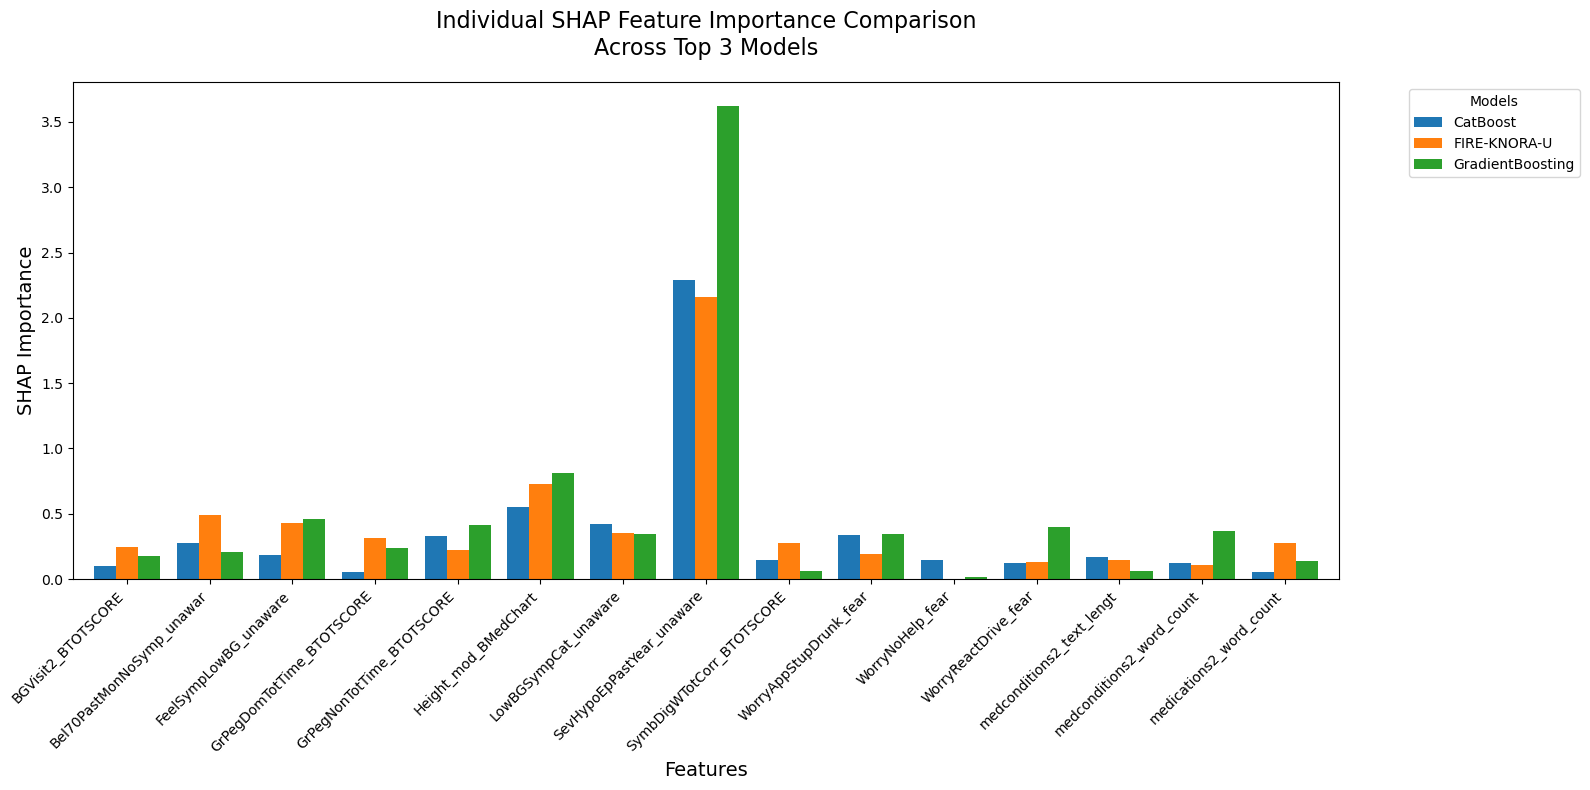


Averaged SHAP values shape: (60, 50)
Final sample size: 60
📁 Saved: averaged_shap_feature_importance.png
📁 Saved: averaged_shap_feature_importance.png


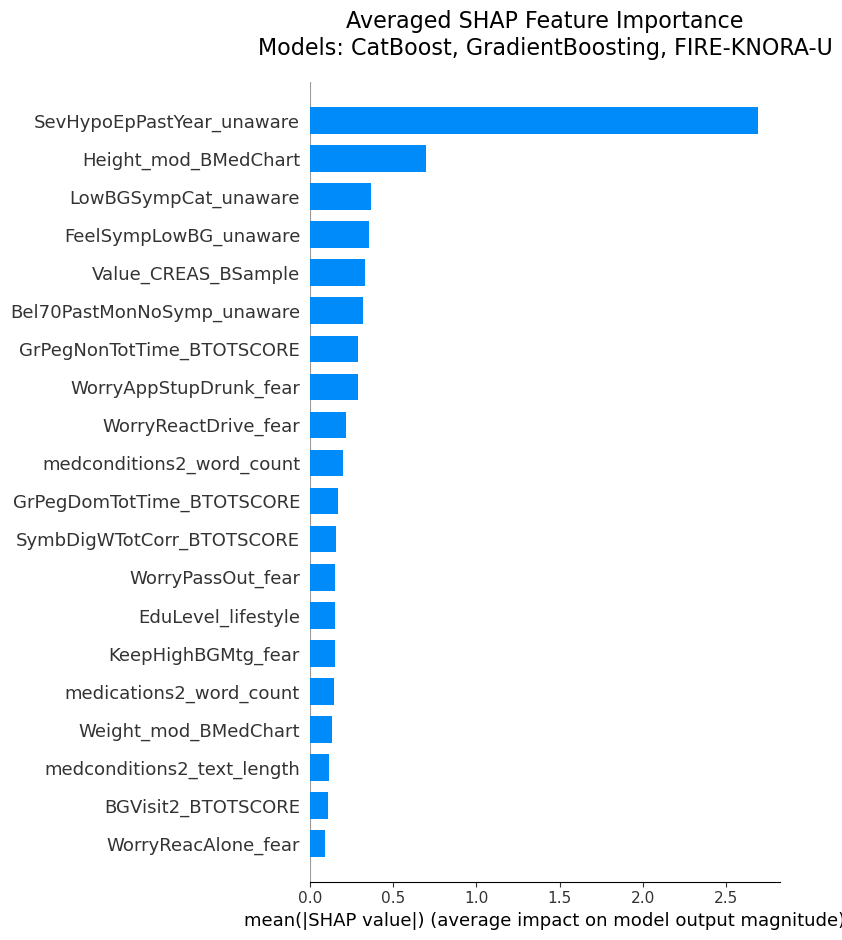


📋 COMPREHENSIVE SHAP ANALYSIS SUMMARY:

🏆 INDIVIDUAL MODEL ANALYSIS:
   1. CatBoost            : Acc=0.8033, AUC=0.8980
      Most Important Feature: SevHypoEpPastYear_unaware (2.2875)
   2. GradientBoosting    : Acc=0.7933, AUC=0.8687
      Most Important Feature: SevHypoEpPastYear_unaware (3.6218)
   3. FIRE-KNORA-U        : Acc=0.7883, AUC=0.8436
      Most Important Feature: SevHypoEpPastYear_unaware (2.1613)

🔍 FEATURE CONSISTENCY ANALYSIS:
   Features appearing in multiple top-5 lists:
      • SevHypoEpPastYear_unaware          : 3/3 models
      • Height_mod_BMedChart               : 3/3 models
      • GrPegNonTotTime_BTOTSCORE          : 2/3 models
      • FeelSympLowBG_unaware              : 2/3 models

✅ Individual SHAP analysis completed successfully!
📊 Analyzed 3 models individually
📁 Generated detailed comparison visualizations
💾 All plots saved as PNG files in current directory


In [28]:
# Numpy fix for bool type
if not hasattr(np, 'bool'):
    np.bool = bool

# SHAP Analysis for Best Performing Models
if 'overall_performance' in locals() and len(overall_performance) > 0:
    print("="*60)
    print("INDIVIDUAL SHAP ANALYSIS FOR TOP 3 MODELS")
    print("="*60)
    
    # Get top 3 models from the comprehensive analysis
    top_3_models = overall_performance[:3]
    print(f"Automatically selected top 3 models for individual SHAP analysis:")
    for i, (model_name, accuracy, _, _, _, _, _, auc, _) in enumerate(top_3_models, 1):
        print(f"  {i}. {model_name:<20}: Accuracy={accuracy:.4f}, AUC={auc:.4f}")
    
    # Prepare data for SHAP analysis using the last random state configuration
    X = splitted_dataset.drop(TARGET_COLUMN, axis=1)
    y = splitted_dataset[TARGET_COLUMN]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=0
    )
    
    # Outlier removal and preprocessing (same as training)
    lof = LocalOutlierFactor()
    yhat = lof.fit_predict(X_train)
    mask = yhat != -1
    X_train, y_train = X_train[mask], y_train[mask]
    
    # SMOTE and scaling
    smote = SMOTE(random_state=0)
    X_res, y_res = smote.fit_resample(X_train, y_train)
    
    scaler = MinMaxScaler()
    X_res_scaled = scaler.fit_transform(X_res)
    X_test_scaled = scaler.transform(X_test)
    
    # Feature selection (top 50 features)
    rf_selector = RandomForestClassifier(n_estimators=100, random_state=0, max_depth=10)
    rf_selector.fit(X_res_scaled, y_res)
    feature_importance = rf_selector.feature_importances_
    indices = np.argsort(feature_importance)[::-1]
    top_features = [X.columns[i] for i in indices[:CONFIG['TOP_FEATURES_COUNT']]]
    
    # Prepare final datasets
    X_res_final = pd.DataFrame(X_res_scaled, columns=X.columns)[top_features]
    X_test_final = pd.DataFrame(X_test_scaled, columns=X.columns)[top_features]
    
    print(f"\nData prepared for SHAP analysis:")
    print(f"Training samples: {X_res_final.shape[0]}")
    print(f"Test samples: {X_test_final.shape[0]}")
    print(f"Features: {X_res_final.shape[1]}")
    
    # Map model names to actual model classes with optimized hyperparameters
    model_mapping = {
        # Classical models
        'DT': DecisionTreeClassifier(random_state=0, criterion='gini', max_depth=6, min_samples_leaf=10, min_samples_split=9),
        'LR': LogisticRegression(random_state=0, C=0.09659168435718246, max_iter=1000, solver='lbfgs'),
        'NB': GaussianNB(var_smoothing=0.0058873326349240295),
        'KNN': KNeighborsClassifier(metric='manhattan', n_neighbors=8, weights='uniform'),
        'MLP': MLPClassifier(random_state=0, max_iter=2000, alpha=0.0003079393718075164, hidden_layer_sizes=(195,), learning_rate_init=0.0001675266159417717),
        'SVC': SVC(probability=True, kernel='rbf', C=0.95, gamma='scale', random_state=0),
        'ExtraTrees': ExtraTreesClassifier(n_estimators=100, random_state=0, max_depth=10, min_samples_split=5),
        'Bagging': BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5, random_state=0), n_estimators=50, random_state=0),
        
        # Static/Ensemble models
        'RF': RandomForestClassifier(n_estimators=143, criterion='entropy', max_depth=15, random_state=0),
        'XGB': XGBClassifier(n_estimators=200, max_depth=3, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=0),
        'GB': GradientBoostingClassifier(n_estimators=300, max_depth=3, learning_rate=0.05, random_state=0),
        'AdaBoost': AdaBoostClassifier(n_estimators=200, learning_rate=0.5, algorithm='SAMME', random_state=0),
        'HistGB': HistGradientBoostingClassifier(max_iter=200, learning_rate=0.1, max_depth=5, random_state=0),
        'CatBoost': CatBoostClassifier(depth=3, iterations=168, learning_rate=0.1, verbose=0, random_state=0),
        'VotingHard': VotingClassifier(
            estimators=[
                ('rf', RandomForestClassifier(n_estimators=100, random_state=0)),
                ('xgb', XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=0)),
                ('gb', GradientBoostingClassifier(n_estimators=100, random_state=0))
            ], voting='hard'
        ),
        'VotingSoft': VotingClassifier(
            estimators=[
                ('rf', RandomForestClassifier(n_estimators=100, random_state=0)),
                ('xgb', XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=0)),
                ('gb', GradientBoostingClassifier(n_estimators=100, random_state=0))
            ], voting='soft'
        ),
        
        # Hyperopt models (use same as static for SHAP)
        'RandomForest': RandomForestClassifier(n_estimators=143, criterion='entropy', max_depth=15, random_state=0),
        'XGBoost': XGBClassifier(n_estimators=200, max_depth=3, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=0),
        'GradientBoosting': GradientBoostingClassifier(n_estimators=300, max_depth=3, learning_rate=0.05, random_state=0),
        
        # DES models - we'll create base models for these
        'KNORAE': RandomForestClassifier(n_estimators=100, random_state=0),
        'KNORAU': XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=0),
        'DESMI': GradientBoostingClassifier(n_estimators=100, random_state=0),
        'METADES': RandomForestClassifier(n_estimators=100, random_state=0),
        'DESKNN': KNeighborsClassifier(n_neighbors=15, weights='uniform'),
        'DESP': DecisionTreeClassifier(random_state=0, max_depth=10),
        'KNOP': RandomForestClassifier(n_estimators=100, random_state=0),
        'FIRE-KNORA-U': XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=0),
        'FIRE-KNORA-E': RandomForestClassifier(n_estimators=100, random_state=0),
        'FIRE-METADES': GradientBoostingClassifier(n_estimators=100, random_state=0),
        'FIRE-DESKNN': KNeighborsClassifier(n_neighbors=15, weights='uniform'),
        'FIRE-DESP': DecisionTreeClassifier(random_state=0, max_depth=10),
        'FIRE-KNOP': RandomForestClassifier(n_estimators=100, random_state=0),
    }
    
    # Sample data for faster SHAP computation
    sample_size = min(100, X_test_final.shape[0])
    X_sample = X_test_final.sample(n=sample_size, random_state=0)
    background_size = min(50, X_res_final.shape[0])
    X_background = X_res_final.sample(n=background_size, random_state=0)
    
    print(f"Using {sample_size} test samples and {background_size} background samples")
    
    # INDIVIDUAL SHAP Analysis for each model
    individual_results = {}
    all_shap_values = []
    model_names_used = []
    
    for i, (model_name, accuracy, _, _, _, _, _, auc, _) in enumerate(top_3_models, 1):
        if model_name in model_mapping:
            try:
                print(f"\n🔄 Processing {i}. {model_name}...")
                
                # Train fresh model for this specific analysis
                model = model_mapping[model_name]
                model.fit(X_res_final, y_res)
                
                # Choose appropriate SHAP explainer based on model type
                if hasattr(model, 'tree_') or 'Forest' in str(type(model)) or 'XGB' in str(type(model)) or 'CatBoost' in str(type(model)) or 'Gradient' in str(type(model)):
                    # Tree-based models
                    explainer = shap.TreeExplainer(model)
                    shap_values = explainer.shap_values(X_sample)
                    
                    # Handle multi-class output
                    if isinstance(shap_values, list):
                        shap_values_processed = shap_values[1] if len(shap_values) > 1 else shap_values[0]
                    else:
                        shap_values_processed = shap_values
                        
                elif 'Voting' in str(type(model)):
                    # For voting classifiers, use the first estimator as proxy
                    base_model = model.estimators_[0]
                    if hasattr(base_model, 'tree_') or 'Forest' in str(type(base_model)):
                        explainer = shap.TreeExplainer(base_model)
                        shap_values = explainer.shap_values(X_sample)
                    else:
                        explainer = shap.KernelExplainer(model.predict_proba, X_background)
                        shap_values = explainer.shap_values(X_sample[:20])  # Smaller sample for kernel
                        X_sample_curr = X_sample[:20]  # Update sample to match
                    
                    if isinstance(shap_values, list):
                        shap_values_processed = shap_values[1] if len(shap_values) > 1 else shap_values[0]
                    else:
                        shap_values_processed = shap_values
                        
                elif 'KNeighbors' in str(type(model)):
                    # For KNN, use KernelExplainer with smaller sample
                    explainer = shap.KernelExplainer(model.predict_proba, X_background)
                    shap_values = explainer.shap_values(X_sample[:20])  # Use smaller sample for kernel
                    X_sample_curr = X_sample[:20]  # Update sample to match
                    
                    if isinstance(shap_values, list):
                        shap_values_processed = shap_values[1] if len(shap_values) > 1 else shap_values[0]
                    else:
                        shap_values_processed = shap_values
                        
                else:
                    # For other models, use KernelExplainer (slower but more general)
                    explainer = shap.KernelExplainer(model.predict_proba, X_background)
                    shap_values = explainer.shap_values(X_sample[:20])  # Use smaller sample for kernel
                    X_sample_curr = X_sample[:20]  # Update sample to match
                    
                    if isinstance(shap_values, list):
                        shap_values_processed = shap_values[1] if len(shap_values) > 1 else shap_values[0]
                    else:
                        shap_values_processed = shap_values
                
                # Calculate individual feature importance for this model
                individual_importance = np.abs(shap_values_processed).mean(axis=0)
                top_feature_indices = np.argsort(individual_importance)[::-1][:10]
                
                # Store individual results
                individual_results[model_name] = {
                    'importance': individual_importance,
                    'top_indices': top_feature_indices,
                    'shap_values': shap_values_processed,
                    'accuracy': accuracy,
                    'auc': auc
                }
                
                # Store for averaging
                all_shap_values.append(shap_values_processed)
                model_names_used.append(model_name)
                
                # Display individual results immediately
                print(f"\n📊 {model_name} Individual Results:")
                print(f"   Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")
                print(f"   Top 5 Most Important Features:")
                for j, feat_idx in enumerate(top_feature_indices[:5], 1):
                    feature_name = X_sample.columns[feat_idx]
                    importance = individual_importance[feat_idx]
                    print(f"      {j}. {feature_name:<35}: {importance:.4f}")
                
            except Exception as e:
                print(f"✗ Error generating SHAP explanations for {model_name}: {e}")
                continue
        else:
            print(f"⚠ Warning: Model {model_name} not found in model mapping. Skipping.")
            continue
    
    # Generate comparison visualization if we have multiple models
    if len(individual_results) >= 2:
        print(f"\n📊 Creating individual and averaged SHAP visualizations...")
        
        # 1. Individual Feature Importance Comparison
        plt.figure(figsize=(16, 10))
        
        # Get all unique features that appear in top 10 of any model
        all_important_features = set()
        for model_data in individual_results.values():
            top_features_model = [X_sample.columns[i] for i in model_data['top_indices'][:10]]
            all_important_features.update(top_features_model)
        
        all_important_features = list(all_important_features)[:15]  # Limit to top 15 overall
        
        # Create comparison data
        comparison_data = []
        for feature in all_important_features:
            feat_idx = X_sample.columns.get_loc(feature)
            for model_name, model_data in individual_results.items():
                importance = model_data['importance'][feat_idx]
                comparison_data.append({
                    'Feature': feature[:25],  # Truncate long feature names
                    'Model': model_name,
                    'Importance': importance
                })
        
        comparison_df = pd.DataFrame(comparison_data)
        
        # Create grouped bar plot
        pivot_df = comparison_df.pivot(index='Feature', columns='Model', values='Importance').fillna(0)
        ax = pivot_df.plot(kind='bar', figsize=(16, 8), width=0.8)
        plt.title('Individual SHAP Feature Importance Comparison\nAcross Top 3 Models', 
                 fontsize=16, pad=20)
        plt.xlabel('Features', fontsize=14)
        plt.ylabel('SHAP Importance', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        
        if CONFIG['SAVE_PLOTS']:
            plt.savefig('individual_shap_comparison.png', dpi=300, bbox_inches='tight')
            print("📁 Saved: individual_shap_comparison.png")
        
        plt.show()
        
        # 2. Averaged SHAP Analysis
        if len(all_shap_values) >= 2:
            # Ensure all SHAP values have the same shape
            min_samples = min([shap_vals.shape[0] for shap_vals in all_shap_values])
            X_sample_final = X_sample.iloc[:min_samples]
            
            # Truncate all SHAP values to same size and average them
            truncated_shap_values = [shap_vals[:min_samples] for shap_vals in all_shap_values]
            averaged_shap_values = np.mean(truncated_shap_values, axis=0)
            
            print(f"\nAveraged SHAP values shape: {averaged_shap_values.shape}")
            print(f"Final sample size: {min_samples}")
            
            # Averaged SHAP Feature Importance Plot
            plt.figure(figsize=(14, 8))
            shap.summary_plot(
                averaged_shap_values,
                X_sample_final,
                plot_type='bar',
                max_display=20,
                show=False
            )
            
            model_list = ", ".join(model_names_used)
            plt.title(f'Averaged SHAP Feature Importance\nModels: {model_list}', 
                     fontsize=16, pad=20)
            plt.tight_layout()
            
            if CONFIG['SAVE_PLOTS']:
                plt.savefig('averaged_shap_feature_importance.png', dpi=300, bbox_inches='tight')
                print("📁 Saved: averaged_shap_feature_importance.png")
            
            plt.show()
        
        # Summary
        print(f"\n📋 COMPREHENSIVE SHAP ANALYSIS SUMMARY:")
        print("=" * 70)
        
        print(f"\n🏆 INDIVIDUAL MODEL ANALYSIS:")
        for i, (model_name, model_data) in enumerate(individual_results.items(), 1):
            accuracy = model_data['accuracy']
            auc = model_data['auc']
            top_feature = X_sample.columns[model_data['top_indices'][0]]
            top_importance = model_data['importance'][model_data['top_indices'][0]]
            
            print(f"   {i}. {model_name:<20}: Acc={accuracy:.4f}, AUC={auc:.4f}")
            print(f"      Most Important Feature: {top_feature} ({top_importance:.4f})")
        
        # Feature consistency analysis
        print(f"\n🔍 FEATURE CONSISTENCY ANALYSIS:")
        top_features_by_model = {}
        for model_name, model_data in individual_results.items():
            top_features_by_model[model_name] = [X_sample.columns[i] for i in model_data['top_indices'][:5]]
        
        # Find features that appear in top 5 of multiple models
        all_top_features = []
        for features in top_features_by_model.values():
            all_top_features.extend(features)
        
        from collections import Counter
        feature_counts = Counter(all_top_features)
        consistent_features = [feat for feat, count in feature_counts.items() if count > 1]
        
        if consistent_features:
            print(f"   Features appearing in multiple top-5 lists:")
            for feature in consistent_features:
                count = feature_counts[feature]
                print(f"      • {feature:<35}: {count}/{len(individual_results)} models")
        else:
            print(f"   No features appear consistently across models (indicates model diversity)")
        
        print(f"\n✅ Individual SHAP analysis completed successfully!")
        print(f"📊 Analyzed {len(individual_results)} models individually")
        print(f"📁 Generated detailed comparison visualizations")
        if CONFIG['SAVE_PLOTS']:
            print(f"💾 All plots saved as PNG files in current directory")
    
    else:
        print("⚠️ Not enough models successfully analyzed for comparison.")
        
else:
    print("⚠️ No comprehensive analysis results available for SHAP analysis.")
    print("Please run the complete training pipeline first to generate 'overall_performance' rankings.")